In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# 크롤링 start_date, end_date
start_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
pred_days=int(input('How many days do you want to predict? (Prophet에만 해당) ex) 365 : '))

YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : 2018-01-01
YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : 2020-10-26
How many days do you want to predict? (Prophet에만 해당) ex) 365 : 10


In [3]:
# !pip install scikitplot

# 1. 라이브러리

In [4]:
import pandas as pd #데이터 분석
import numpy as np #행렬 연산

import datetime # 날짜타입 사용
import random # 시드 제어

import seaborn as sns # 시각화
import matplotlib.pyplot as plt # 시각화
import scikitplot    #   conda install -c conda-forge scikit-plot  (사전에 설치)

from workalendar.asia import SouthKorea # 한국의 공휴일
import random # 시드 제어

import talib as ta # 기술적 분석 (보조지표)

from pycaret.regression import * # AutoML pycaret
#from pycaret.classification import * # AutoML pycaret
from fbprophet import Prophet # Prophet

import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx


# 2. 입력 데이터

1) 데이터 수집기간 입력

In [5]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [6]:
print(start_date__)
print(end_date__)

20180101
20201026


# 2. 데이터 수집 (코스피지수 예측 모델)  -> Data_kospi.csv

1) 코스피 차트 데이터 및 투자지표

In [7]:
# 종합지수 (코스피) 차트 데이터
kospi_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1001")
kospi_.columns = ['Open','High','Low','Close','Volume']

# 코스피 투자자별 공매도 거래량
kospi_short_sell_volume = stock.get_shorting_investor_volume_by_date(start_date__, end_date__, "KOSPI")
kospi_short_sell_volume.columns = ['kospi_inst_volume','kospi_indi_volume','kospi_fore_volume','kospi_etc_volume','kospi_short_sell_volume']

# 코스피 투자자별 공매도 거래대금
kospi_short_sell_value = stock.get_shorting_investor_price_by_date(start_date__, end_date__, "KOSPI")
kospi_short_sell_value.columns = ['kospi_inst_value','kospi_indi_value','kospi_fore_value','kospi_etc_value','kospi_short_sell_value']

# 참고
# 코스피 항목별 시장 거래량
#kospi_market_volume = stock.get_market_trading_volume_by_date(start_date__, end_date__, "KOSPI")
# 코스피 항목별 시장 거래대금
#kospi_market_value = stock.get_market_trading_value_by_date(start_date__, end_date__, "KOSPI")

In [8]:
kospi_short_sell_volume

,kospi_inst_volume,kospi_indi_volume,kospi_fore_volume,kospi_etc_volume,kospi_short_sell_volume
날짜,,,,,
2018-01-02,1910431,8162,6183648,0,8102241
2018-01-03,1124108,15388,5843969,0,6983465
2018-01-04,2250404,9091,5610926,0,7870421
2018-01-05,2346393,26271,6354870,0,8727534
2018-01-08,1826219,10661,5381423,0,7218303
...,...,...,...,...,...
2020-10-20,245619,0,0,0,245619
2020-10-21,241417,0,0,0,241417
2020-10-22,186146,0,0,0,186146


2) 코스피 관련 주가지수

In [9]:
# 대표지수 (코스피 200)
kospi_200_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1028")
kospi_200_.columns = ['kospi_200_Open','kospi_200_High','kospi_200_Low','kospi_200_Close','kospi_200_Volume']
kospi_200_ = kospi_200_.drop(['kospi_200_Open','kospi_200_High','kospi_200_Low','kospi_200_Volume'], axis=1)

# 대표지수 (코스피 200 중소형주)
kospi_200_midnsmall_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1167")
kospi_200_midnsmall_.columns = ['kospi_200_midnsmall_Open','kospi_200_midnsmall_High','kospi_200_midnsmall_Low','kospi_200_midnsmall_Close','kospi_200_midnsmall_Volume']
kospi_200_midnsmall_ = kospi_200_midnsmall_.drop(['kospi_200_midnsmall_Open','kospi_200_midnsmall_High','kospi_200_midnsmall_Low','kospi_200_midnsmall_Volume'], axis=1)

# 대표지수 (코스피 200 초대형제외 지수)
kospi_200_exbig_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1182")
kospi_200_exbig_.columns = ['kospi_200_exbig_Open','kospi_200_exbig_High','kospi_200_exbig_Low','kospi_200_exbig_Close','kospi_200_exbig_Volume']
kospi_200_exbig_ = kospi_200_exbig_.drop(['kospi_200_exbig_Open','kospi_200_exbig_High','kospi_200_exbig_Low','kospi_200_exbig_Volume'], axis=1)

# 섹터지수 (코스피 200 커뮤니케이션 서비스)
kospi_200_comm_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1150")
kospi_200_comm_.columns = ['kospi_200_comm_Open','kospi_200_comm_High','kospi_200_comm_Low','kospi_200_comm_Close','kospi_200_comm_Volume']
kospi_200_comm_ = kospi_200_comm_.drop(['kospi_200_comm_Open','kospi_200_comm_High','kospi_200_comm_Low','kospi_200_comm_Volume'], axis=1)

# 섹터지수 (코스피 200 건설)
kospi_200_const_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1151")
kospi_200_const_.columns = ['kospi_200_const_Open','kospi_200_const_High','kospi_200_const_Low','kospi_200_const_Close','kospi_200_const_Volume']
kospi_200_const_ = kospi_200_const_.drop(['kospi_200_const_Open','kospi_200_const_High','kospi_200_const_Low','kospi_200_const_Volume'], axis=1)

# 섹터지수 (코스피 200 중공업)
kospi_200_heavy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1152")
kospi_200_heavy_.columns = ['kospi_200_heavy_Open','kospi_200_heavy_High','kospi_200_heavy_Low','kospi_200_heavy_Close','kospi_200_heavy_Volume']
kospi_200_heavy_ = kospi_200_heavy_.drop(['kospi_200_heavy_Open','kospi_200_heavy_High','kospi_200_heavy_Low','kospi_200_heavy_Volume'], axis=1)

# 섹터지수 (코스피 200 철강/소재)
kospi_200_steel_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1153")
kospi_200_steel_.columns = ['kospi_200_steel_Open','kospi_200_steel_High','kospi_200_steel_Low','kospi_200_steel_Close','kospi_200_steel_Volume']
kospi_200_steel_ = kospi_200_steel_.drop(['kospi_200_steel_Open','kospi_200_steel_High','kospi_200_steel_Low','kospi_200_steel_Volume'], axis=1)

# 섹터지수 (코스피 200 에너지/화학)
kospi_200_energy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1154")
kospi_200_energy_.columns = ['kospi_200_energy_Open','kospi_200_energy_High','kospi_200_energy_Low','kospi_200_energy_Close','kospi_200_energy_Volume']
kospi_200_energy_ = kospi_200_energy_.drop(['kospi_200_energy_Open','kospi_200_energy_High','kospi_200_energy_Low','kospi_200_energy_Volume'], axis=1)

# 섹터지수 (코스피 200 정보기술)
kospi_200_info_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1155")
kospi_200_info_.columns = ['kospi_200_info_Open','kospi_200_info_High','kospi_200_info_Low','kospi_200_info_Close','kospi_200_info_Volume']
kospi_200_info_ = kospi_200_info_.drop(['kospi_200_info_Open','kospi_200_info_High','kospi_200_info_Low','kospi_200_info_Volume'], axis=1)

# 섹터지수 (코스피 200 금융)
kospi_200_finance_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1156")
kospi_200_finance_.columns = ['kospi_200_finance_Open','kospi_200_finance_High','kospi_200_finance_Low','kospi_200_finance_Close','kospi_200_finance_Volume']
kospi_200_finance_ = kospi_200_finance_.drop(['kospi_200_finance_Open','kospi_200_finance_High','kospi_200_finance_Low','kospi_200_finance_Volume'], axis=1)

# 섹터지수 (코스피 200 생활소비재)
kospi_200_life_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1157")
kospi_200_life_.columns = ['kospi_200_life_Open','kospi_200_life_High','kospi_200_life_Low','kospi_200_life_Close','kospi_200_life_Volume']
kospi_200_life_ = kospi_200_life_.drop(['kospi_200_life_Open','kospi_200_life_High','kospi_200_life_Low','kospi_200_life_Volume'], axis=1)

# 섹터지수 (코스피 200 경기소비재)
kospi_200_economy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1158")
kospi_200_economy_.columns = ['kospi_200_economy_Open','kospi_200_economy_High','kospi_200_economy_Low','kospi_200_economy_Close','kospi_200_economy_Volume']
kospi_200_economy_ = kospi_200_economy_.drop(['kospi_200_economy_Open','kospi_200_economy_High','kospi_200_economy_Low','kospi_200_economy_Volume'], axis=1)

# 섹터지수 (코스피 200 산업재)
kospi_200_industy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1159")
kospi_200_industy_.columns = ['kospi_200_industy_Open','kospi_200_industy_High','kospi_200_industy_Low','kospi_200_industy_Close','kospi_200_industy_Volume']
kospi_200_industy_ = kospi_200_industy_.drop(['kospi_200_industy_Open','kospi_200_industy_High','kospi_200_industy_Low','kospi_200_industy_Volume'], axis=1)

# 섹터지수 (코스피 200 헬스케어)
kospi_200_health_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1160")
kospi_200_health_.columns = ['kospi_200_health_Open','kospi_200_health_High','kospi_200_health_Low','kospi_200_health_Close','kospi_200_health_Volume']
kospi_200_health_ = kospi_200_health_.drop(['kospi_200_health_Open','kospi_200_health_High','kospi_200_health_Low','kospi_200_health_Volume'], axis=1)

3) 환율 데이터

In [10]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# 유로/원
exchange_rate_eur_ = investpy.get_currency_cross_historical_data(currency_cross='EUR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_eur_.columns = ['exchange_rate_eur_Open', 'exchange_rate_eur_High', 'exchange_rate_eur_Low', 'exchange_rate_eur_Close', 'exchange_rate_eur_Currency']
exchange_rate_eur_ = exchange_rate_eur_.drop(['exchange_rate_eur_Open','exchange_rate_eur_High','exchange_rate_eur_Low','exchange_rate_eur_Currency'], axis=1)

# 엔/원
exchange_rate_jpy_ = investpy.get_currency_cross_historical_data(currency_cross='JPY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_jpy_.columns = ['exchange_rate_jpy_Open', 'exchange_rate_jpy_High', 'exchange_rate_jpy_Low', 'exchange_rate_jpy_Close', 'exchange_rate_jpy_Currency']
exchange_rate_jpy_ = exchange_rate_jpy_.drop(['exchange_rate_jpy_Open','exchange_rate_jpy_High','exchange_rate_jpy_Low','exchange_rate_jpy_Currency'], axis=1)

# 위안/원
exchange_rate_cny_ = investpy.get_currency_cross_historical_data(currency_cross='CNY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_cny_.columns = ['exchange_rate_cny_Open', 'exchange_rate_cny_High', 'exchange_rate_cny_Low', 'exchange_rate_cny_Close', 'exchange_rate_cny_Currency']
exchange_rate_cny_ = exchange_rate_cny_.drop(['exchange_rate_cny_Open','exchange_rate_cny_High','exchange_rate_cny_Low','exchange_rate_cny_Currency'], axis=1)

# 호주 달러/원
exchange_rate_aud_ = investpy.get_currency_cross_historical_data(currency_cross='AUD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_aud_.columns = ['exchange_rate_aud_Open', 'exchange_rate_aud_High', 'exchange_rate_aud_Low', 'exchange_rate_aud_Close', 'exchange_rate_aud_Currency']
exchange_rate_aud_ = exchange_rate_aud_.drop(['exchange_rate_aud_Open','exchange_rate_aud_High','exchange_rate_aud_Low','exchange_rate_aud_Currency'], axis=1)

# 캐나다 달러/원
exchange_rate_cad_ = investpy.get_currency_cross_historical_data(currency_cross='CAD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_cad_.columns = ['exchange_rate_cad_Open', 'exchange_rate_cad_High', 'exchange_rate_cad_Low', 'exchange_rate_cad_Close', 'exchange_rate_cad_Currency']
exchange_rate_cad_ = exchange_rate_cad_.drop(['exchange_rate_cad_Open','exchange_rate_cad_High','exchange_rate_cad_Low','exchange_rate_cad_Currency'], axis=1)

# 스위스 프랑/원
exchange_rate_chf_ = investpy.get_currency_cross_historical_data(currency_cross='CHF/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_chf_.columns = ['exchange_rate_chf_Open', 'exchange_rate_chf_High', 'exchange_rate_chf_Low', 'exchange_rate_chf_Close', 'exchange_rate_chf_Currency']
exchange_rate_chf_ = exchange_rate_chf_.drop(['exchange_rate_chf_Open','exchange_rate_chf_High','exchange_rate_chf_Low','exchange_rate_chf_Currency'], axis=1)

# 파운드/원
exchange_rate_gbp_ = investpy.get_currency_cross_historical_data(currency_cross='GBP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_gbp_.columns = ['exchange_rate_gbp_Open', 'exchange_rate_gbp_High', 'exchange_rate_gbp_Low', 'exchange_rate_gbp_Close', 'exchange_rate_gbp_Currency']
exchange_rate_gbp_ = exchange_rate_gbp_.drop(['exchange_rate_gbp_Open','exchange_rate_gbp_High','exchange_rate_gbp_Low','exchange_rate_gbp_Currency'], axis=1)

# 홍콩 달러/원
exchange_rate_hkd_ = investpy.get_currency_cross_historical_data(currency_cross='HKD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_hkd_.columns = ['exchange_rate_hkd_Open', 'exchange_rate_hkd_High', 'exchange_rate_hkd_Low', 'exchange_rate_hkd_Close', 'exchange_rate_hkd_Currency']
exchange_rate_hkd_ = exchange_rate_hkd_.drop(['exchange_rate_hkd_Open','exchange_rate_hkd_High','exchange_rate_hkd_Low','exchange_rate_hkd_Currency'], axis=1)

# 인도네시아 루피아/원
exchange_rate_idr_ = investpy.get_currency_cross_historical_data(currency_cross='IDR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_idr_.columns = ['exchange_rate_idr_Open', 'exchange_rate_idr_High', 'exchange_rate_idr_Low', 'exchange_rate_idr_Close', 'exchange_rate_idr_Currency']
exchange_rate_idr_ = exchange_rate_idr_.drop(['exchange_rate_idr_Open','exchange_rate_idr_High','exchange_rate_idr_Low','exchange_rate_idr_Currency'], axis=1)

# 인도 루피/원
exchange_rate_inr_ = investpy.get_currency_cross_historical_data(currency_cross='INR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_inr_.columns = ['exchange_rate_inr_Open', 'exchange_rate_inr_High', 'exchange_rate_inr_Low', 'exchange_rate_inr_Close', 'exchange_rate_inr_Currency']
exchange_rate_inr_ = exchange_rate_inr_.drop(['exchange_rate_inr_Open','exchange_rate_inr_High','exchange_rate_inr_Low','exchange_rate_inr_Currency'], axis=1)

# 말레이시아 링깃/원
exchange_rate_myr_ = investpy.get_currency_cross_historical_data(currency_cross='MYR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_myr_.columns = ['exchange_rate_myr_Open', 'exchange_rate_myr_High', 'exchange_rate_myr_Low', 'exchange_rate_myr_Close', 'exchange_rate_myr_Currency']
exchange_rate_myr_ = exchange_rate_myr_.drop(['exchange_rate_myr_Open','exchange_rate_myr_High','exchange_rate_myr_Low','exchange_rate_myr_Currency'], axis=1)

# 뉴질랜드 달러/원
exchange_rate_nzd_ = investpy.get_currency_cross_historical_data(currency_cross='NZD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_nzd_.columns = ['exchange_rate_nzd_Open', 'exchange_rate_nzd_High', 'exchange_rate_nzd_Low', 'exchange_rate_nzd_Close', 'exchange_rate_nzd_Currency']
exchange_rate_nzd_ = exchange_rate_nzd_.drop(['exchange_rate_nzd_Open','exchange_rate_nzd_High','exchange_rate_nzd_Low','exchange_rate_nzd_Currency'], axis=1)

# 싱가폴 달러/원
exchange_rate_sgd_ = investpy.get_currency_cross_historical_data(currency_cross='SGD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_sgd_.columns = ['exchange_rate_sgd_Open', 'exchange_rate_sgd_High', 'exchange_rate_sgd_Low', 'exchange_rate_sgd_Close', 'exchange_rate_sgd_Currency']
exchange_rate_sgd_ = exchange_rate_sgd_.drop(['exchange_rate_sgd_Open','exchange_rate_sgd_High','exchange_rate_sgd_Low','exchange_rate_sgd_Currency'], axis=1)

# 태국 바트/원
exchange_rate_thb_ = investpy.get_currency_cross_historical_data(currency_cross='THB/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_thb_.columns = ['exchange_rate_thb_Open', 'exchange_rate_thb_High', 'exchange_rate_thb_Low', 'exchange_rate_thb_Close', 'exchange_rate_thb_Currency']
exchange_rate_thb_ = exchange_rate_thb_.drop(['exchange_rate_thb_Open','exchange_rate_thb_High','exchange_rate_thb_Low','exchange_rate_thb_Currency'], axis=1)

# 대만 신타이비/원
exchange_rate_twd_ = investpy.get_currency_cross_historical_data(currency_cross='TWD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_twd_.columns = ['exchange_rate_twd_Open', 'exchange_rate_twd_High', 'exchange_rate_twd_Low', 'exchange_rate_twd_Close', 'exchange_rate_twd_Currency']
exchange_rate_twd_ = exchange_rate_twd_.drop(['exchange_rate_twd_Open','exchange_rate_twd_High','exchange_rate_twd_Low','exchange_rate_twd_Currency'], axis=1)

# 남아프리카 란드/원
exchange_rate_zar_ = investpy.get_currency_cross_historical_data(currency_cross='ZAR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_zar_.columns = ['exchange_rate_zar_Open', 'exchange_rate_zar_High', 'exchange_rate_zar_Low', 'exchange_rate_zar_Close', 'exchange_rate_zar_Currency']
exchange_rate_zar_ = exchange_rate_zar_.drop(['exchange_rate_zar_Open','exchange_rate_zar_High','exchange_rate_zar_Low','exchange_rate_zar_Currency'], axis=1)

# 디르함/원
exchange_rate_aed_ = investpy.get_currency_cross_historical_data(currency_cross='AED/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_aed_.columns = ['exchange_rate_aed_Open', 'exchange_rate_aed_High', 'exchange_rate_aed_Low', 'exchange_rate_aed_Close', 'exchange_rate_aed_Currency']
exchange_rate_aed_ = exchange_rate_aed_.drop(['exchange_rate_aed_Open','exchange_rate_aed_High','exchange_rate_aed_Low','exchange_rate_aed_Currency'], axis=1)

# 아르헨티나 페소/원
exchange_rate_ars_ = investpy.get_currency_cross_historical_data(currency_cross='ARS/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_ars_.columns = ['exchange_rate_ars_Open', 'exchange_rate_ars_High', 'exchange_rate_ars_Low', 'exchange_rate_ars_Close', 'exchange_rate_ars_Currency']
exchange_rate_ars_ = exchange_rate_ars_.drop(['exchange_rate_ars_Open','exchange_rate_ars_High','exchange_rate_ars_Low','exchange_rate_ars_Currency'], axis=1)

# 브라질 헤안/원
exchange_rate_brl_ = investpy.get_currency_cross_historical_data(currency_cross='BRL/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_brl_.columns = ['exchange_rate_brl_Open', 'exchange_rate_brl_High', 'exchange_rate_brl_Low', 'exchange_rate_brl_Close', 'exchange_rate_brl_Currency']
exchange_rate_brl_ = exchange_rate_brl_.drop(['exchange_rate_brl_Open','exchange_rate_brl_High','exchange_rate_brl_Low','exchange_rate_brl_Currency'], axis=1)

# 칠레 페소/원
exchange_rate_clp_ = investpy.get_currency_cross_historical_data(currency_cross='CLP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_clp_.columns = ['exchange_rate_clp_Open', 'exchange_rate_clp_High', 'exchange_rate_clp_Low', 'exchange_rate_clp_Close', 'exchange_rate_clp_Currency']
exchange_rate_clp_ = exchange_rate_clp_.drop(['exchange_rate_clp_Open','exchange_rate_clp_High','exchange_rate_clp_Low','exchange_rate_clp_Currency'], axis=1)

# 덴마크 크로네/원
exchange_rate_dkk_ = investpy.get_currency_cross_historical_data(currency_cross='DKK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_dkk_.columns = ['exchange_rate_dkk_Open', 'exchange_rate_dkk_High', 'exchange_rate_dkk_Low', 'exchange_rate_dkk_Close', 'exchange_rate_dkk_Currency']
exchange_rate_dkk_ = exchange_rate_dkk_.drop(['exchange_rate_dkk_Open','exchange_rate_dkk_High','exchange_rate_dkk_Low','exchange_rate_dkk_Currency'], axis=1)

# 헝가리 포린트/원
exchange_rate_huf_ = investpy.get_currency_cross_historical_data(currency_cross='HUF/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_huf_.columns = ['exchange_rate_huf_Open', 'exchange_rate_huf_High', 'exchange_rate_huf_Low', 'exchange_rate_huf_Close', 'exchange_rate_huf_Currency']
exchange_rate_huf_ = exchange_rate_huf_.drop(['exchange_rate_huf_Open','exchange_rate_huf_High','exchange_rate_huf_Low','exchange_rate_huf_Currency'], axis=1)

# 이스라엘 세켈/원
exchange_rate_ils_ = investpy.get_currency_cross_historical_data(currency_cross='ILS/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_ils_.columns = ['exchange_rate_ils_Open', 'exchange_rate_ils_High', 'exchange_rate_ils_Low', 'exchange_rate_ils_Close', 'exchange_rate_ils_Currency']
exchange_rate_ils_ = exchange_rate_ils_.drop(['exchange_rate_ils_Open','exchange_rate_ils_High','exchange_rate_ils_Low','exchange_rate_ils_Currency'], axis=1)

# 아이스랜드 크로나/원
exchange_rate_isk_ = investpy.get_currency_cross_historical_data(currency_cross='ISK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_isk_.columns = ['exchange_rate_isk_Open', 'exchange_rate_isk_High', 'exchange_rate_isk_Low', 'exchange_rate_isk_Close', 'exchange_rate_isk_Currency']
exchange_rate_isk_ = exchange_rate_isk_.drop(['exchange_rate_isk_Open','exchange_rate_isk_High','exchange_rate_isk_Low','exchange_rate_isk_Currency'], axis=1)

# 멕시코 페소/원
exchange_rate_mxn_ = investpy.get_currency_cross_historical_data(currency_cross='MXN/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_mxn_.columns = ['exchange_rate_mxn_Open', 'exchange_rate_mxn_High', 'exchange_rate_mxn_Low', 'exchange_rate_mxn_Close', 'exchange_rate_mxn_Currency']
exchange_rate_mxn_ = exchange_rate_mxn_.drop(['exchange_rate_mxn_Open','exchange_rate_mxn_High','exchange_rate_mxn_Low','exchange_rate_mxn_Currency'], axis=1)

# 노르웨이 크로네/원
exchange_rate_nok_ = investpy.get_currency_cross_historical_data(currency_cross='NOK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_nok_.columns = ['exchange_rate_nok_Open', 'exchange_rate_nok_High', 'exchange_rate_nok_Low', 'exchange_rate_nok_Close', 'exchange_rate_nok_Currency']
exchange_rate_nok_ = exchange_rate_nok_.drop(['exchange_rate_nok_Open','exchange_rate_nok_High','exchange_rate_nok_Low','exchange_rate_nok_Currency'], axis=1)

# 필리핀 페소/원
exchange_rate_php_ = investpy.get_currency_cross_historical_data(currency_cross='PHP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_php_.columns = ['exchange_rate_php_Open', 'exchange_rate_php_High', 'exchange_rate_php_Low', 'exchange_rate_php_Close', 'exchange_rate_php_Currency']
exchange_rate_php_ = exchange_rate_php_.drop(['exchange_rate_php_Open','exchange_rate_php_High','exchange_rate_php_Low','exchange_rate_php_Currency'], axis=1)

# 파키스탄 루피/원
exchange_rate_pkr_ = investpy.get_currency_cross_historical_data(currency_cross='PKR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_pkr_.columns = ['exchange_rate_pkr_Open', 'exchange_rate_pkr_High', 'exchange_rate_pkr_Low', 'exchange_rate_pkr_Close', 'exchange_rate_pkr_Currency']
exchange_rate_pkr_ = exchange_rate_pkr_.drop(['exchange_rate_pkr_Open','exchange_rate_pkr_High','exchange_rate_pkr_Low','exchange_rate_pkr_Currency'], axis=1)

# 폴란드 즈워티/원
exchange_rate_pln_ = investpy.get_currency_cross_historical_data(currency_cross='PLN/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_pln_.columns = ['exchange_rate_pln_Open', 'exchange_rate_pln_High', 'exchange_rate_pln_Low', 'exchange_rate_pln_Close', 'exchange_rate_pln_Currency']
exchange_rate_pln_ = exchange_rate_pln_.drop(['exchange_rate_pln_Open','exchange_rate_pln_High','exchange_rate_pln_Low','exchange_rate_pln_Currency'], axis=1)

# 러시아 루블/원
exchange_rate_rub_ = investpy.get_currency_cross_historical_data(currency_cross='RUB/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_rub_.columns = ['exchange_rate_rub_Open', 'exchange_rate_rub_High', 'exchange_rate_rub_Low', 'exchange_rate_rub_Close', 'exchange_rate_rub_Currency']
exchange_rate_rub_ = exchange_rate_rub_.drop(['exchange_rate_rub_Open','exchange_rate_rub_High','exchange_rate_rub_Low','exchange_rate_rub_Currency'], axis=1)

# 리얄/원
exchange_rate_sar_ = investpy.get_currency_cross_historical_data(currency_cross='SAR/KRW', from_date=start_date_, to_date=end_date_) 
exchange_rate_sar_.columns = ['exchange_rate_sar_Open', 'exchange_rate_sar_High', 'exchange_rate_sar_Low', 'exchange_rate_sar_Close', 'exchange_rate_sar_Currency']
exchange_rate_sar_ = exchange_rate_sar_.drop(['exchange_rate_sar_Open','exchange_rate_sar_High','exchange_rate_sar_Low','exchange_rate_sar_Currency'], axis=1)

# 스웨덴 크로나/원
exchange_rate_sek_ = investpy.get_currency_cross_historical_data(currency_cross='SEK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_sek_.columns = ['exchange_rate_sek_Open', 'exchange_rate_sek_High', 'exchange_rate_sek_Low', 'exchange_rate_sek_Close', 'exchange_rate_sek_Currency']
exchange_rate_sek_ = exchange_rate_sek_.drop(['exchange_rate_sek_Open','exchange_rate_sek_High','exchange_rate_sek_Low','exchange_rate_sek_Currency'], axis=1)

# 터키 리라/원
exchange_rate_try_ = investpy.get_currency_cross_historical_data(currency_cross='TRY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_try_.columns = ['exchange_rate_try_Open', 'exchange_rate_try_High', 'exchange_rate_try_Low', 'exchange_rate_try_Close', 'exchange_rate_try_Currency']
exchange_rate_try_ = exchange_rate_try_.drop(['exchange_rate_try_Open','exchange_rate_try_High','exchange_rate_try_Low','exchange_rate_try_Currency'], axis=1)

4) 원자재 데이터 (금값시세, 유가 등)

In [11]:
# [*금속*]
# comex 금 시세
comex_gold_ = yf.download("GC=F", start=start_date, end=end_date)
comex_gold_.columns = ['comex_gold_Open','comex_gold_High','comex_gold_Low','comex_gold_Close','comex_gold_Adj Close','comex_gold_Volume']
comex_gold_ = comex_gold_.drop(['comex_gold_Open','comex_gold_High','comex_gold_Low','comex_gold_Adj Close','comex_gold_Volume'], axis=1)

# comex 미니 금 시세
comex_mini_gold_ = yf.download("MGC=F", start=start_date, end=end_date)
comex_mini_gold_.columns = ['comex_mini_gold_Open','comex_mini_gold_High','comex_mini_gold_Low','comex_mini_gold_Close','comex_mini_gold_Adj Close','comex_mini_gold_Volume']
comex_mini_gold_ = comex_mini_gold_.drop(['comex_mini_gold_Open','comex_mini_gold_High','comex_mini_gold_Low','comex_mini_gold_Adj Close','comex_mini_gold_Volume'], axis=1)

# comex 은 시세
comex_silver_ = yf.download("SI=F", start=start_date, end=end_date)
comex_silver_.columns = ['comex_silver_Open','comex_silver_High','comex_silver_Low','comex_silver_Close','comex_silver_Adj Close','comex_silver_Volume']
comex_silver_ = comex_silver_.drop(['comex_silver_Open','comex_silver_High','comex_silver_Low','comex_silver_Adj Close','comex_silver_Volume'], axis=1)

# comex 미니 은 시세
comex_mini_silver_ = yf.download("SIL=F", start=start_date, end=end_date)
comex_mini_silver_.columns = ['comex_mini_silver_Open','comex_mini_silver_High','comex_mini_silver_Low','comex_mini_silver_Close','comex_mini_silver_Adj Close','comex_mini_silver_Volume']
comex_mini_silver_ = comex_mini_silver_.drop(['comex_mini_silver_Open','comex_mini_silver_High','comex_mini_silver_Low','comex_mini_silver_Adj Close','comex_mini_silver_Volume'], axis=1)

# comex 동(구리) 시세
comex_copper_ = yf.download("PL=F", start=start_date, end=end_date)
comex_copper_.columns = ['comex_copper_Open','comex_copper_High','comex_copper_Low','comex_copper_Close','comex_copper_Adj Close','comex_copper_Volume']
comex_copper_ = comex_copper_.drop(['comex_copper_Open','comex_copper_High','comex_copper_Low','comex_copper_Adj Close','comex_copper_Volume'], axis=1)

# 미국 플래티넘 시세
platinum_ = yf.download("HG=F", start=start_date, end=end_date)
platinum_.columns = ['platinum_Open','platinum_High','platinum_Low','platinum_Close','platinum_Adj Close','platinum_Volume']
platinum_ = platinum_.drop(['platinum_Open','platinum_High','platinum_Low','platinum_Adj Close','platinum_Volume'], axis=1)

# 미국 팔라듐 시세
palladium_ = yf.download("PA=F", start=start_date, end=end_date)
palladium_.columns = ['palladium_Open','palladium_High','palladium_Low','palladium_Close','palladium_Adj Close','palladium_Volume']
palladium_ = palladium_.drop(['palladium_Open','palladium_High','palladium_Low','palladium_Adj Close','palladium_Volume'], axis=1)

# [*에너지*]
# WTI유 시세
crude_oil_ = yf.download("CL=F", start=start_date, end=end_date)
crude_oil_.columns = ['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Close','crude_oil_Adj Close','crude_oil_Volume']
crude_oil_ = crude_oil_.drop(['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Adj Close','crude_oil_Volume'], axis=1)

# 브렌트유 시세
brent_crude_oil_ = yf.download("BZ=F", start=start_date, end=end_date)
brent_crude_oil_.columns = ['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Close','brent_crude_oil_Adj Close','brent_crude_oil_Volume']
brent_crude_oil_ = brent_crude_oil_.drop(['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Adj Close','brent_crude_oil_Volume'], axis=1)

# 가솔린 RBOB 시세
rbob_gasoilne_ = yf.download("RB=F", start=start_date, end=end_date)
rbob_gasoilne_.columns = ['rbob_gasoilne_Open','rbob_gasoilne_High','rbob_gasoilne_Low','rbob_gasoilne_Close','rbob_gasoilne_Adj Close','rbob_gasoilne_Volume']
rbob_gasoilne_ = rbob_gasoilne_.drop(['rbob_gasoilne_Open','rbob_gasoilne_High','rbob_gasoilne_Low','rbob_gasoilne_Adj Close','rbob_gasoilne_Volume'], axis=1)

# 미국 천연가스 시세
natural_gas_ = yf.download("NG=F", start=start_date, end=end_date)
natural_gas_.columns = ['natural_gas_Open','natural_gas_High','natural_gas_Low','natural_gas_Close','natural_gas_Adj Close','natural_gas_Volume']
natural_gas_ = natural_gas_.drop(['natural_gas_Open','natural_gas_High','natural_gas_Low','natural_gas_Adj Close','natural_gas_Volume'], axis=1)

# 미국 난방유 시세
heating_oil_ = yf.download("HO=F", start=start_date, end=end_date)
heating_oil_.columns = ['heating_oil_Open','heating_oil_High','heating_oil_Low','heating_oil_Close','heating_oil_Adj Close','heating_oil_Volume']
heating_oil_ = heating_oil_.drop(['heating_oil_Open','heating_oil_High','heating_oil_Low','heating_oil_Adj Close','heating_oil_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


5) 금리 데이터

In [12]:
# 미국 국채 수익률 (13주)
treasury_13w_ = yf.download("^IRX", start=start_date, end=end_date)
treasury_13w_.columns = ['treasury_13w_Open','treasury_13w_High','treasury_13w_Low','treasury_13w_Close','treasury_13w_Adj Close','treasury_13w_Volume']
treasury_13w_ = treasury_13w_.drop(['treasury_13w_Open','treasury_13w_High','treasury_13w_Low','treasury_13w_Adj Close','treasury_13w_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)

# 미국 국채 수익률 (10년)
treasury_10y_ = yf.download("^TNX", start=start_date, end=end_date)
treasury_10y_.columns = ['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Close','treasury_10y_Adj Close','treasury_10y_Volume']
treasury_10y_ = treasury_10y_.drop(['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Adj Close','treasury_10y_Volume'], axis=1)

# 미국 국채 수익률 (30년)
treasury_30y_ = yf.download("^TYX", start=start_date, end=end_date)
treasury_30y_.columns = ['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Close','treasury_30y_Adj Close','treasury_30y_Volume']
treasury_30y_ = treasury_30y_.drop(['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Adj Close','treasury_30y_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


6) 글로벌 주가지수

In [13]:
# Vix
vix_ = yf.download("^VIX", start=start_date, end=end_date)
vix_.columns = ['vix_Open','vix_High','vix_Low','vix_Close','vix_Adj Close','vix_Volume']
vix_ = vix_.drop(['vix_Open','vix_High','vix_Low','vix_Adj Close','vix_Volume'], axis=1)

# KOSPI Volatility
vkospi_ = investpy.get_index_historical_data(index='KOSPI Volatility',country='South Korea', from_date=start_date_,to_date=end_date_)
vkospi_.columns = ['vkospi_Open','vkospi_High','vkospi_Low','vkospi_Close','vkospi_Volume','vkospi_Currency']
vkospi_ = vkospi_.drop(['vkospi_Open','vkospi_High','vkospi_Low','vkospi_Volume','vkospi_Currency'], axis=1)

# Bitcoin USD
bitcoin_ = yf.download("BTC-USD", start=start_date, end=end_date)
bitcoin_.columns = ['bitcoin_Open','bitcoin_High','bitcoin_Low','bitcoin_Close','bitcoin_Adj Close','bitcoin_Volume']
bitcoin_ = bitcoin_.drop(['bitcoin_Open','bitcoin_High','bitcoin_Low','bitcoin_Adj Close','bitcoin_Volume'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# Dow Jones
dow_jones_ = yf.download("^DJI", start=start_date, end=end_date)
dow_jones_.columns = ['dow_jones_Open','dow_jones_High','dow_jones_Low','dow_jones_Close','dow_jones_Adj Close','dow_jones_Volume']
dow_jones_ = dow_jones_.drop(['dow_jones_Open','dow_jones_High','dow_jones_Low','dow_jones_Adj Close','dow_jones_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# NYSE
nyse_ = yf.download("^NYA", start=start_date, end=end_date)
nyse_.columns = ['nyse_Open','nyse_High','nyse_Low','nyse_Close','nyse_Adj Close','nyse_Volume']
nyse_ = nyse_.drop(['nyse_Open','nyse_High','nyse_Low','nyse_Adj Close','nyse_Volume'], axis=1)

# AMEX
amex_ = yf.download("^XAX", start=start_date, end=end_date)
amex_.columns = ['amex_Open','amex_High','amex_Low','amex_Close','amex_Adj Close','amex_Volume']
amex_ = amex_.drop(['amex_Open','amex_High','amex_Low','amex_Adj Close','amex_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# DAX
dax_ = yf.download("^GDAXI", start=start_date, end=end_date)
dax_.columns = ['dax_Open','dax_High','dax_Low','dax_Close','dax_Adj Close','dax_Volume']
dax_ = dax_.drop(['dax_Open','dax_High','dax_Low','dax_Adj Close','dax_Volume'], axis=1)

# Nikkei 225
nikkei_225_ = yf.download("^N225", start=start_date, end=end_date)
nikkei_225_.columns = ['nikkei_225_Open','nikkei_225_High','nikkei_225_Low','nikkei_225_Close','nikkei_225_Adj Close','nikkei_225_Volume']
nikkei_225_ = nikkei_225_.drop(['nikkei_225_Open','nikkei_225_High','nikkei_225_Low','nikkei_225_Adj Close','nikkei_225_Volume'], axis=1)

# HANG SENG
hang_seng_ = yf.download("^HSI", start=start_date, end=end_date)
hang_seng_.columns = ['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Close','hang_seng_Adj Close','hang_seng_Volume']
hang_seng_ = hang_seng_.drop(['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Adj Close','hang_seng_Volume'], axis=1)

# SSE
sse_ = yf.download("000001.SS", start=start_date, end=end_date)
sse_.columns = ['sse_Open','sse_High','sse_Low','sse_Close','sse_Adj Close','sse_Volume']
sse_ = sse_.drop(['sse_Open','sse_High','sse_Low','sse_Adj Close','sse_Volume'], axis=1)

# ESTX 50
estx_50_ = yf.download("^STOXX50E", start=start_date, end=end_date)
estx_50_.columns = ['estx_50_Open','estx_50_High','estx_50_Low','estx_50_Close','estx_50_Adj Close','estx_50_Volume']
estx_50_ = estx_50_.drop(['estx_50_Open','estx_50_High','estx_50_Low','estx_50_Adj Close','estx_50_Volume'], axis=1)

# EURONEXT 100
euronext_100_ = yf.download("^N100", start=start_date, end=end_date)
euronext_100_.columns = ['euronext_100_Open','euronext_100_High','euronext_100_Low','euronext_100_Close','euronext_100_Adj Close','euronext_100_Volume']
euronext_100_ = euronext_100_.drop(['euronext_100_Open','euronext_100_High','euronext_100_Low','euronext_100_Adj Close','euronext_100_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


8) 배출권

# 3. 데이터 수집 (와이지엔터 주가예측 모델)  -> Data_yg.csv

1) 와이지엔터테인먼트 차트 데이터

In [14]:
# 차트 데이터
yg_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "122870")
yg_.columns = ['Open','High','Low','Close','Volume']

# 특정 종목의 일자별 시가총액을 조회
yg_market_cap = stock.get_market_cap_by_date(start_date__, end_date__, "122870")
yg_market_cap.columns = ['Market_Value','Volume','Value','Num_Stock']
del yg_market_cap['Volume']

2) 와이지엔터테인먼트 투자지표

In [15]:
# 특정 종목에 대해 입력된 기간의 DIV/BPS/PER/EPS
yg_fundamental = stock.get_market_fundamental_by_date(start_date__, end_date__, "122870")


# 시작일/종료일/티커 세 개의 파라미터를 입력받아 공매도 현황을 DataFrame으로 반환
yg_short_sell = stock.get_shorting_status_by_date(start_date__, end_date__, "122870")
yg_short_sell.columns = ['yg_short_sell','yg_balance','yg_short_sell_value','yg_balance_value']

# 입력받은 종목에 대해 주어진 기간 동안의 공매도 거래 정보를 반환
yg_short_sell_vol = stock.get_shorting_volume_by_date(start_date__, end_date__, "122870")
yg_short_sell_vol.columns = ['yg_short_sell_volume','yg_total_volume', 'yg_short_sell_rate', 'yg_short_sell_value']

3) 코스닥 주가지수 및 관련 투자지표

In [16]:
# 종합지수 (코스닥) 차트 데이터
kosdaq_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2001")
kosdaq_.columns = ['kosdaq_Open','kosdaq_High','kosdaq_Low','kosdaq_Close','kosdaq_Volume']

# 코스닥 투자자별 공매도 거래량
kosdaq_short_sell_volume = stock.get_shorting_investor_volume_by_date(start_date__, end_date__, "KOSDAQ")
kosdaq_short_sell_volume.columns = ['kosdaq_inst_volume','kosdaq_indi_volume','kosdaq_fore_volume','kosdaq_etc_volume','kosdaq_short_sell_volume']

# 코스닥 투자자별 공매도 거래대금
kosdaq_short_sell_value = stock.get_shorting_investor_price_by_date(start_date__, end_date__, "KOSDAQ")
kosdaq_short_sell_value.columns = ['kosdaq_inst_value','kosdaq_indi_value','kosdaq_fore_value','kosdaq_etc_value','kosdaq_short_sell_value']

# 참고
# 코스닥 항목별 시장 거래량
#kosdaq_market_volume = stock.get_market_trading_volume_by_date(start_date__, end_date__, "KOSDAQ")
# 코스닥 항목별 시장 거래대금
#kosdaq_market_value = stock.get_market_trading_value_by_date(start_date__, end_date__, "KOSDAQ")

# 대표지수 (코스닥 150)
kosdaq_150 = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2203")
kosdaq_150.columns = ['kosdaq_150_Open','kosdaq_150_High','kosdaq_150_Low','kosdaq_150_Close','kosdaq_150_Volume']
kosdaq_150 = kosdaq_150.drop(['kosdaq_150_Open','kosdaq_150_High','kosdaq_150_Low','kosdaq_150_Volume'], axis=1)

# 섹터지수 (코스닥 150 커뮤니케이션서비스)
kosdaq_150_comm = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2218")
kosdaq_150_comm.columns = ['kosdaq_150_comm_Open','kosdaq_150_comm_High','kosdaq_150_comm_Low','kosdaq_150_comm_Close','kosdaq_150_comm_Volume']
kosdaq_150_comm = kosdaq_150_comm.drop(['kosdaq_150_comm_Open','kosdaq_150_comm_High','kosdaq_150_comm_Low','kosdaq_150_comm_Volume'], axis=1)

# 산업별지수 (오락, 문화)
kosdaq_enter = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2037")
kosdaq_enter.columns = ['kosdaq_enter_Open','kosdaq_enter_High','kosdaq_enter_Low','kosdaq_enter_Close','kosdaq_enter_Volume']
kosdaq_enter = kosdaq_enter.drop(['kosdaq_enter_Open','kosdaq_enter_High','kosdaq_enter_Low','kosdaq_enter_Volume'], axis=1)

# 시가총액 규모별 지수 (코스닥 대형주)
kosdaq_large = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2002")
kosdaq_large.columns = ['kosdaq_large_Open','kosdaq_large_High','kosdaq_large_Low','kosdaq_large_Close','kosdaq_large_Volume']
kosdaq_large = kosdaq_large.drop(['kosdaq_large_Open','kosdaq_large_High','kosdaq_large_Low','kosdaq_large_Volume'], axis=1)

# 소속부 지수 (코스닥 우량기업부)
kosdaq_super = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2181")
kosdaq_super.columns = ['kosdaq_super_Open','kosdaq_super_High','kosdaq_super_Low','kosdaq_super_Close','kosdaq_super_Volume']
kosdaq_super = kosdaq_super.drop(['kosdaq_super_Open','kosdaq_super_High','kosdaq_super_Low','kosdaq_super_Volume'], axis=1)

# 4. 데이터 전처리 (코스피지수 예측 모델)

1) 예측 대상 설정

In [17]:
model_kospi = kospi_.copy()

2) 라벨링 (등락 여부, 동일 : 0, 상승 : 1, 하락 : 2)

3) 보조지표

In [18]:
# 보조지표 추가
# 1) 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
model_kospi['ma_5'] = ta.SMA(model_kospi.Close, timeperiod=5)
model_kospi['ma_10'] = ta.SMA(model_kospi.Close, timeperiod=10)
model_kospi['ma_15'] = ta.SMA(model_kospi.Close, timeperiod=15)
model_kospi['ma_20'] = ta.SMA(model_kospi.Close, timeperiod=20)
model_kospi['ma_30'] = ta.SMA(model_kospi.Close, timeperiod=30)
model_kospi['ma_60'] = ta.SMA(model_kospi.Close, timeperiod=60)
model_kospi['ma_120'] = ta.SMA(model_kospi.Close, timeperiod=120)

model_kospi['ema_5'] = ta.EMA(model_kospi.Close, timeperiod=5)
model_kospi['ema_10'] = ta.EMA(model_kospi.Close, timeperiod=10)
model_kospi['ema_15'] = ta.EMA(model_kospi.Close, timeperiod=15)
model_kospi['ema_20'] = ta.EMA(model_kospi.Close, timeperiod=20)
model_kospi['ema_30'] = ta.EMA(model_kospi.Close, timeperiod=30)
model_kospi['ema_60'] = ta.EMA(model_kospi.Close, timeperiod=60)
model_kospi['ema_120'] = ta.EMA(model_kospi.Close, timeperiod=120)

model_kospi['wma_5'] = ta.WMA(model_kospi.Close, timeperiod=5)
model_kospi['wma_10'] = ta.WMA(model_kospi.Close, timeperiod=10)
model_kospi['wma_15'] = ta.WMA(model_kospi.Close, timeperiod=15)
model_kospi['wma_20'] = ta.WMA(model_kospi.Close, timeperiod=20)
model_kospi['wma_30'] = ta.WMA(model_kospi.Close, timeperiod=30)
model_kospi['wma_60'] = ta.WMA(model_kospi.Close, timeperiod=60)
model_kospi['wma_120'] = ta.WMA(model_kospi.Close, timeperiod=120)

model_kospi['ma_v5'] = ta.SMA(model_kospi.Volume, timeperiod=5)
model_kospi['ma_v10'] = ta.SMA(model_kospi.Volume, timeperiod=10)
model_kospi['ma_v20'] = ta.SMA(model_kospi.Volume, timeperiod=20)
model_kospi['ma_v60'] = ta.SMA(model_kospi.Volume, timeperiod=60)
model_kospi['ma_v120'] = ta.SMA(model_kospi.Volume, timeperiod=120)

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
ubb, mbb, lbb = ta.BBANDS(model_kospi.Close, 20, 2)
model_kospi['ubb'] = ubb
model_kospi['mbb'] = mbb
model_kospi['lbb'] = lbb

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_kospi.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_kospi['macd'] = macd
model_kospi['macdsignal9'] = macdsignal9
model_kospi['macdhist'] = macdhist

# 4) RSI 상대강도지수 - 추세의 강도 파악, 과매수, 과매도 국면 판단
model_kospi['rsi'] = ta.RSI(model_kospi.Close, timeperiod=14)

# 5) 스토캐스틱 오늘의 주가가 일정 동안 주가의 변동폭 중에서 어느 정도인 지?
slowk, slowd = ta.STOCH(model_kospi.High, model_kospi.Low, model_kospi.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
fastk, fastd = ta.STOCHF(model_kospi.High, model_kospi.Low, model_kospi.Close, fastk_period=5, fastd_period=3, fastd_matype=0)
fastk_rsi, fastd_rsi = ta.STOCHRSI(model_kospi.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
model_kospi['slowk'] = slowk
model_kospi['slowd'] = slowd
model_kospi['fastk'] = fastk
model_kospi['fastd'] = fastd
model_kospi['fastk_rsi'] = fastk_rsi
model_kospi['fastd_rsi'] = fastd_rsi

# 6) 기타 자주 사용되는 것들
# CCI (Commodity Channel Index), williams'%R, parabolic SAR
# ADX (Average Directional Movement Index)
# plusDI(Plus Directional Indicator), plusDM Plus Directional Movement)
# ATR (Average True Range), OBV (On Balance Volume) 거래량 분석을 통한 주가분석, Variance
model_kospi['cci'] = ta.CCI(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['willR'] = ta.WILLR(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['sar'] = ta.SAR(model_kospi.High, model_kospi.Low, acceleration=0, maximum=0)
model_kospi['adx'] = ta.ADX(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['plus_di'] = ta.PLUS_DI(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['plus_dm'] = ta.PLUS_DM(model_kospi.High, model_kospi.Low, timeperiod=14)
model_kospi['atr'] = ta.ATR(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['obv'] = ta.OBV(model_kospi.Close, model_kospi.Volume)
model_kospi['var'] = ta.VAR(model_kospi.Close, timeperiod=5, nbdev=1)

In [19]:
# kospi 모델
lst_label = ['a']
for i in range(len(model_kospi)-1):
    if model_kospi.iloc[i+1]['Close'] == model_kospi.iloc[i]['Close']:
        lst_label.append(2) # 전일 주가 = 당일 주가 : 2
    elif model_kospi.iloc[i+1]['Close'] > model_kospi.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 < 당일 주가 : 0
    else:
        lst_label.append(1) # 전일 주가 > 당일 주가 : 1
model_kospi['Labeling'] = lst_label
model_kospi = model_kospi.drop(model_kospi[model_kospi['Labeling'] == 'a'].index) # 첫 행 삭제
model_kospi = model_kospi.drop(model_kospi[model_kospi['Labeling'] == 2].index) # 전일 주가 = 당일 주가인 행 삭제
model_kospi['Labeling'] = model_kospi['Labeling'].astype("category")
model_kospi = model_kospi.dropna() # 결측치가 있는 행 제거

4) 분석 데이터 조합

In [20]:
model_yg = yg_.copy()

In [21]:
# 분석 데이터 병합

model_yg=pd.merge(model_yg,yg_market_cap, how='inner', left_index=True, right_index=True)

# # 피쳐 스케일링
# def feature_scaling(df, scaling_strategy="min-max", column=None):
#     if column == None:
#         column = [column_name for column_name in df.columns]
#     for column_name in column:
#         if scaling_strategy == "min-max":
#             df[column_name] = ( df[column_name] - df[column_name].min() ) /\
#                             (df[column_name].max() - df[column_name].min()) 
#         elif scaling_strategy == "z-score":
#             df[column_name] = ( df[column_name] - \
#                                df[column_name].mean() ) /\
#                             (df[column_name].std() )
#     return df

# scaling_col = [column for column in model_kospi.columns.difference(['Labeling'])]

# model_kospi = model_kospi.dropna()
# model_kospi = feature_scaling(model_kospi, scaling_strategy="z-score", column=scaling_col)

#model_kospi.to_csv("Data_kospi.csv", mode='w', index=False)

# 5. 데이터 전처리 (와이지엔터 주가예측 모델)

1) 예측 대상 설정

2) 라벨링 (등락 여부, 동일 : 0, 상승 : 1, 하락 : 2)

3) 보조지표

In [22]:
# 보조지표 추가
# 1) 보조지표 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
#SMA : 단순 이동평균 / EMA : 지수 이동평균 / WMA : 가중평균 이동평균
model_yg['ma_5'] = ta.SMA(model_yg.Close, timeperiod=5)
model_yg['ma_10'] = ta.SMA(model_yg.Close, timeperiod=10)
model_yg['ma_15'] = ta.SMA(model_yg.Close, timeperiod=15)
model_yg['ma_20'] = ta.SMA(model_yg.Close, timeperiod=20)
model_yg['ma_30'] = ta.SMA(model_yg.Close, timeperiod=30)
model_yg['ma_60'] = ta.SMA(model_yg.Close, timeperiod=60)
model_yg['ma_120'] = ta.SMA(model_yg.Close, timeperiod=120)

model_yg['ema_5'] = ta.EMA(model_yg.Close, timeperiod=5)
model_yg['ema_10'] = ta.EMA(model_yg.Close, timeperiod=10)
model_yg['ema_15'] = ta.EMA(model_yg.Close, timeperiod=15)
model_yg['ema_20'] = ta.EMA(model_yg.Close, timeperiod=20)
model_yg['ema_30'] = ta.EMA(model_yg.Close, timeperiod=30)
model_yg['ema_60'] = ta.EMA(model_yg.Close, timeperiod=60)
model_yg['ema_120'] = ta.EMA(model_yg.Close, timeperiod=120)

model_yg['wma_5'] = ta.WMA(model_yg.Close, timeperiod=5)
model_yg['wma_10'] = ta.WMA(model_yg.Close, timeperiod=10)
model_yg['wma_15'] = ta.WMA(model_yg.Close, timeperiod=15)
model_yg['wma_20'] = ta.WMA(model_yg.Close, timeperiod=20)
model_yg['wma_30'] = ta.WMA(model_yg.Close, timeperiod=30)
model_yg['wma_60'] = ta.WMA(model_yg.Close, timeperiod=60)
model_yg['wma_120'] = ta.WMA(model_yg.Close, timeperiod=120)

model_yg['ma_v5'] = ta.SMA(model_yg.Volume, timeperiod=5)
model_yg['ma_v10'] = ta.SMA(model_yg.Volume, timeperiod=10)
model_yg['ma_v20'] = ta.SMA(model_yg.Volume, timeperiod=20)
model_yg['ma_v60'] = ta.SMA(model_yg.Volume, timeperiod=60)
model_yg['ma_v120'] = ta.SMA(model_yg.Volume, timeperiod=120)

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
# UBB = MA_w(x) + k * sd(x)
# MBB = MA_w(x)
# LBB = MA_w(x) - k * sd(x)
# upperband, middleband, lowerband = BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
ubb, mbb, lbb = ta.BBANDS(model_yg.Close, 20, 2)
model_yg['ubb'] = ubb
model_yg['mbb'] = mbb
model_yg['lbb'] = lbb

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_yg.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_yg['macd'] = macd
model_yg['macdsignal9'] = macdsignal9
model_yg['macdhist'] = macdhist

# 4) RSI 상대강도지수 - 추세의 강도 파악, 과매수, 과매도 국면 판단
model_yg['rsi'] = ta.RSI(model_yg.Close, timeperiod=14)

# 5) 스토캐스틱 오늘의 주가가 일정 동안 주가의 변동폭 중에서 어느 정도인 지?
slowk, slowd = ta.STOCH(model_yg.High, model_yg.Low, model_yg.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
fastk, fastd = ta.STOCHF(model_yg.High, model_yg.Low, model_yg.Close, fastk_period=5, fastd_period=3, fastd_matype=0)
fastk_rsi, fastd_rsi = ta.STOCHRSI(model_yg.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
model_yg['slowk'] = slowk
model_yg['slowd'] = slowd
model_yg['fastk'] = fastk
model_yg['fastd'] = fastd
model_yg['fastk_rsi'] = fastk_rsi
model_yg['fastd_rsi'] = fastd_rsi

# 6) 기타 자주 사용되는 것들
# CCI (Commodity Channel Index) : 주가와 이동평균 차이를 나타내는 보조지표
model_yg['cci'] = ta.CCI(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)

# williams'%R : 주어진 기간 동안에 최고점 대비 종가 수준을 반영
model_yg['willR'] = ta.WILLR(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)

# parabolic SAR : 기존의 추세가 지나고 새로운 추세가 시작됨을 반영하는 지표
model_yg['sar'] = ta.SAR(model_yg.High, model_yg.Low, acceleration=0, maximum=0)

# ADX (Average Directional Movement Index) : 전일의 주가와 현재 주가를 비교하여 상승 여부 판단하고 매도세, 매수세 판단
model_yg['adx'] = ta.ADX(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)

# plusDI(Plus Directional Indicator) : 순방향 지시자
model_yg['plus_di'] = ta.PLUS_DI(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)

# plusDM(Plus Directional Movement) : 당일 고가 - 전일 고가
model_yg['plus_dm'] = ta.PLUS_DM(model_yg.High, model_yg.Low, timeperiod=14)

# ATR (Average True Range) : 가격 변동성 측정, True Range(이전시점-현재가격)의 이동평균
model_yg['atr'] = ta.ATR(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)

# OBV (On Balance Volume) 거래량 분석을 통한 주가분석
model_yg['obv'] = ta.OBV(model_yg.Close, model_yg.Volume)

# Variance
model_yg['var'] = ta.VAR(model_yg.Close, timeperiod=5, nbdev=1)

4) 분석 데이터 병합 및 피쳐 스케일링

In [23]:
# 분석 데이터 병합
model_yg=pd.merge(model_yg,yg_market_cap, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_fundamental, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_short_sell, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_short_sell_vol, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_short_sell_volume, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_short_sell_value, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_150, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_150_comm, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_enter, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_large, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_super, how='inner', left_index=True, right_index=True)

# 피쳐 스케일링
# def feature_scaling(df, scaling_strategy="min-max", column=None):
#     if column == None:
#         column = [column_name for column_name in df.columns]
#     for column_name in column:
#         if scaling_strategy == "min-max":
#             df[column_name] = ( df[column_name] - df[column_name].min() ) /\
#                             (df[column_name].max() - df[column_name].min()) 
#         elif scaling_strategy == "z-score":
#             df[column_name] = ( df[column_name] - \
#                                df[column_name].mean() ) /\
#                             (df[column_name].std() )
#     return df

# scaling_col = [column for column in model_yg.columns.difference(['Labeling'])]

# model_yg = model_yg.dropna()
# model_yg = feature_scaling(model_yg, scaling_strategy="z-score", column=scaling_col)

#model_yg.to_csv("Data_yg.csv", mode='w', index=False)

In [24]:
# yg 모델
lst_label = ['a']
for i in range(len(model_yg)-1):
    if model_yg.iloc[i+1]['Close'] == model_yg.iloc[i]['Close']:
        lst_label.append(2) # 전일 주가 = 당일 주가 : 2
    elif model_yg.iloc[i+1]['Close'] > model_yg.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 < 당일 주가 : 0
    else:
        lst_label.append(1) # 전일 주가 > 당일 주가 : 1
model_yg['Labeling'] = lst_label
model_yg = model_yg.drop(model_yg[model_yg['Labeling'] == 'a'].index) # 첫 행 삭제
model_yg = model_yg.drop(model_yg[model_yg['Labeling'] == 2].index) # 전일 주가 = 당일 주가인 행 삭제
model_yg['Labeling'] = model_yg['Labeling'].astype("category")
model_yg = model_yg.dropna() # 결측치가 있는 행 제거

# => YG 데이터 통합본 완성

In [25]:
model_kospi

,Open,High,Low,Close,Volume,ma_5,ma_10,ma_15,ma_20,ma_30,...,cci,willR,sar,adx,plus_di,plus_dm,atr,obv,var,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2018-06-28,2327.37,2335.35,2310.80,2314.24,414371000,2344.458,2354.442,2388.602667,2400.0780,2420.984000,...,-97.443492,-97.961602,2607.1,31.910135,10.389112,41.011871,28.197606,-9.409510e+08,260.759776,1
2018-06-29,2325.68,2329.58,2296.39,2326.13,396663000,2338.240,2346.651,2378.972667,2395.9330,2416.570333,...,-94.052072,-83.763717,2607.1,34.138282,9.526539,38.082451,28.554205,-5.442880e+08,256.705640,0
2018-07-02,2322.23,2327.59,2271.53,2271.54,393266000,2320.972,2336.181,2366.970000,2388.3595,2410.294333,...,-136.506898,-99.995193,2607.1,36.509826,8.276572,35.362276,30.518905,-9.375540e+08,771.153896,1
2018-07-03,2285.88,2287.39,2252.36,2272.76,366028000,2305.340,2329.446,2353.810667,2380.0495,2404.438000,...,-178.371228,-89.779047,2607.1,38.915021,7.605083,32.836399,30.841126,-5.715260e+08,812.297320,0
2018-07-04,2270.95,2280.81,2261.34,2265.46,315103000,2290.026,2319.601,2340.252667,2370.9345,2397.931667,...,-145.805625,-92.768424,2607.1,41.148416,7.252867,30.490942,30.028903,-8.866290e+08,626.630384,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20,2333.56,2358.41,2322.06,2358.41,874293000,2357.674,2374.005,2352.367333,2357.9650,2372.865667,...,-26.409545,-39.984133,2607.1,13.254001,20.306067,99.241195,34.909058,4.115033e+10,182.667944,0
2020-10-21,2363.03,2371.74,2356.32,2370.86,812837000,2355.750,2374.501,2358.911333,2356.1995,2372.031000,...,9.653062,-37.649918,2607.1,13.187585,22.479550,105.482539,33.516983,4.196316e+10,109.717560,0
2020-10-22,2355.61,2360.22,2339.73,2355.05,815612000,2354.518,2371.312,2363.995333,2353.3320,2371.591000,...,-53.923621,-64.582701,2607.1,13.558771,20.980595,97.948072,33.346484,4.114755e+10,102.335416,1


In [26]:
model_yg

,Open,High,Low,Close,Volume,Market_Value_x,Value_x,Num_Stock_x,ma_5,ma_10,...,kosdaq_indi_value,kosdaq_fore_value,kosdaq_etc_value,kosdaq_short_sell_value,kosdaq_150_Close,kosdaq_150_comm_Close,kosdaq_enter_Close,kosdaq_large_Close,kosdaq_super_Close,Labeling
2018-10-18,39650,40150,39150,40000,652646,727428,25974933750,18185709,40570.0,41370.0,...,2063479050,71603013447,0,94326579533,1245.72,2533.36,600.91,1625.89,1301.07,0
2018-10-19,39500,41700,39350,41200,400491,749251,16257487500,18185709,40650.0,41025.0,...,4583845715,102040379680,0,139170083778,1274.33,2584.28,610.37,1662.49,1320.51,0
2018-10-22,41000,42150,40550,41750,226492,759253,9407206400,18185709,40940.0,40880.0,...,2231737090,60153884986,522643410,82777246186,1284.09,2641.20,618.70,1679.36,1323.76,0
2018-10-23,41750,43750,40700,42700,490990,776530,20918344250,18185709,41020.0,41030.0,...,3416146590,120495675946,506500000,167574969203,1235.50,2617.31,610.61,1616.05,1282.12,0
2018-10-24,43900,44000,36450,37050,1200094,673781,46038571450,18185709,40540.0,40520.0,...,2315734710,148175880560,5385760,190890397664,1203.59,2290.13,564.56,1571.19,1251.53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20,42000,43350,41750,42950,426811,789725,18068034250,18387079,44500.0,47110.0,...,0,0,0,4670307484,1252.93,2392.63,478.76,1702.72,1533.37,0
2020-10-21,42750,43600,42350,42600,328871,783290,14086247000,18387079,43390.0,46220.0,...,0,0,0,1966645844,1263.07,2402.36,480.57,1715.08,1542.88,1
2020-10-22,42150,42850,41600,41700,282868,767737,11913260150,18410969,42750.0,45230.0,...,0,0,0,1638772209,1229.13,2346.20,468.73,1670.61,1510.00,1
2020-10-23,41750,42250,40850,41950,359499,772340,14944704100,18410969,42370.0,44445.0,...,0,0,0,2314999965,1220.23,2344.23,468.44,1659.80,1498.29,0


# 1) Prophet

https://facebook.github.io/prophet/docs/quick_start.html

# 1) 코스피

In [27]:
model_kospi.describe()

,Open,High,Low,Close,Volume,ma_5,ma_10,ma_15,ma_20,ma_30,...,fastd_rsi,cci,willR,sar,adx,plus_di,plus_dm,atr,obv,var
count,572.000000,572.000000,572.000000,572.000000,5.720000e+02,572.000000,572.000000,572.000000,572.000000,572.000000,...,5.720000e+02,572.000000,572.000000,5.720000e+02,572.000000,572.000000,572.000000,572.000000,5.720000e+02,572.000000
mean,2136.680629,2148.490000,2121.865332,2135.564388,5.726802e+08,2135.518955,2135.398935,2135.447385,2135.714616,2136.394905,...,5.599521e+01,9.744915,-43.261470,2.607100e+03,25.493330,24.008215,100.045314,30.421120,8.335360e+09,563.884928
std,150.686947,147.134406,152.799920,150.043852,2.618843e+08,148.115204,145.487141,143.028580,140.871825,136.571174,...,3.478284e+01,108.013541,32.052373,1.638523e-11,9.254530,8.509790,48.677598,12.048492,1.180973e+10,1135.738619
min,1474.450000,1516.750000,1439.430000,1457.640000,2.064980e+08,1541.484000,1620.345000,1654.064667,1691.968000,1752.429000,...,-5.684342e-14,-271.707156,-100.000000,2.607100e+03,11.151317,4.423641,22.253664,18.900111,-3.865882e+09,3.895904
25%,2063.977500,2074.217500,2053.765000,2064.662500,3.727658e+08,2066.749500,2066.796500,2065.875500,2066.747125,2073.108833,...,2.480966e+01,-73.413141,-71.925119,2.607100e+03,18.411731,18.375818,63.898757,22.138111,-2.787498e+08,113.241004
50%,2134.150000,2145.105000,2120.690000,2135.010000,5.010560e+08,2135.319000,2132.638500,2133.116000,2131.830000,2130.767000,...,6.088147e+01,22.622074,-39.230516,2.607100e+03,23.578246,23.903157,89.682838,25.986517,3.566168e+09,213.004020
75%,2232.795000,2242.700000,2222.162500,2233.082500,7.371375e+08,2229.867500,2223.219500,2217.649000,2210.239375,2202.265000,...,9.123073e+01,97.944383,-12.777902,2.607100e+03,31.140224,29.253796,126.421349,35.736211,1.119671e+10,501.614744
max,2455.280000,2458.170000,2429.940000,2443.580000,1.984182e+09,2425.196000,2408.626000,2396.570000,2400.078000,2420.984000,...,1.000000e+02,261.630910,-0.000000,2.607100e+03,53.014815,48.822697,271.159326,83.018536,4.305619e+10,11911.593024


In [28]:
import copy
df_kospi=copy.deepcopy(model_kospi) # 깊은 복사

In [29]:
#df.date = df.date.astype(str)
#df.date = df.date.str[:4] + '-' + df.date.str[4:6] + '-' + df.date.str[6:]
df_kospi['date'] = pd.to_datetime(df_kospi.index)

data_kospi = df_kospi[['date', 'Close']].reset_index(drop=True)

data_kospi = data_kospi.rename(columns={'date': 'ds', 'Close': 'y'})

data_kospi.head()

,ds,y
0,2018-06-28,2314.24
1,2018-06-29,2326.13
2,2018-07-02,2271.54
3,2018-07-03,2272.76
4,2018-07-04,2265.46


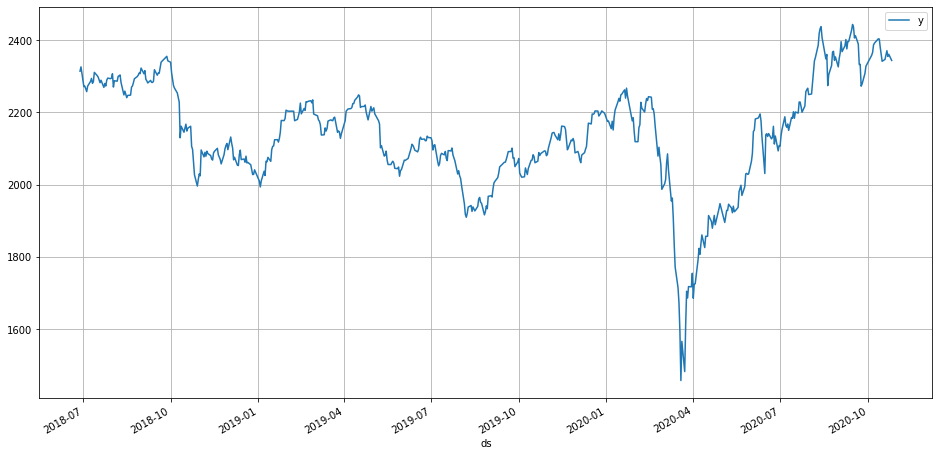

In [30]:
# 코스피 데이터의 추이 파악

data_kospi.plot(x='ds', y='y', figsize=(16, 8))
plt.grid(True)

# 페이스북 Prophet 모델 설명

1) Prophet의 구성요소 : Growth, Seasonality, Holidays
- Growth : changing point 를 자동으로 감지해 트렌드를 형성
- Seasonality : 분기별, 계절별 등 규칙적으로 나타나는 패턴을 반영
- Holidays : 주말, 휴가 등등 불규칙적 패턴 

공식사이트 : https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tunincg

----------
Prophet Parameters    
----------

changepoint_prior_scale: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

seasonality_prior_scale: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

holidays_prior_scale: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

seasonality_mode: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.


changepoint_range: This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, [0.8, 0.95] may be a reasonable range.
Parameters that would likely not be tuned

growth: Options are ‘linear’ and ‘logistic’. This likely will not be tuned; if there is a known saturating point and growth towards that point it will be included and the logistic trend will be used, otherwise it will be linear.

changepoints: This is for manually specifying the locations of changepoints. None by default, which automatically places them.

n_changepoints: This is the number of automatically placed changepoints. The default of 25 should be plenty to capture the trend changes in a typical time series (at least the type that Prophet would work well on anyway). Rather than increasing or decreasing the number of changepoints, it will likely be more effective to focus on increasing or decreasing the flexibility at those trend changes, which is done with changepoint_prior_scale.

yearly_seasonality: By default (‘auto’) this will turn yearly seasonality on if there is a year of data, and off otherwise. Options are [‘auto’, True, False]. If there is more than a year of data, rather than trying to turn this off during HPO, it will likely be more effective to leave it on and turn down seasonal effects by tuning seasonality_prior_scale.

weekly_seasonality: Same as for yearly_seasonality.

daily_seasonality: Same as for yearly_seasonality.

holidays: This is to pass in a dataframe of specified holidays. The holiday effects would be tuned with holidays_prior_scale.

mcmc_samples: Whether or not MCMC is used will likely be determined by factors like the length of the time series and the importance of parameter uncertainty (these considerations are described in the documentation).

interval_width: Prophet predict returns uncertainty intervals for each component, like yhat_lower and yhat_upper for the forecast yhat. These are computed as quantiles of the posterior predictive distribution, and interval_width specifies which quantiles to use. The default of 0.8 provides an 80% prediction interval. You could change that to 0.95 if you wanted a 95% interval. This will affect only the uncertainty interval, and will not change the forecast yhat at all and so does not need to be tuned.

uncertainty_samples: The uncertainty intervals are computed as quantiles from the posterior predictive interval, and the posterior predictive interval is estimated with Monte Carlo sampling. This parameter is the number of samples to use (defaults to 1000). The running time for predict will be linear in this number. Making it smaller will increase the variance (Monte Carlo error) of the uncertainty interval, and making it larger will reduce that variance. So, if the uncertainty estimates seem jagged this could be increased to further smooth them out, but it likely will not need to be changed. As with interval_width, this parameter only affects the uncertainty intervals and changing it will not affect in any way the forecast yhat; it does not need to be tuned.

stan_backend: If both pystan and cmdstanpy backends set up, the backend can be specified. The predictions will be the same, this will not be tuned.


 Parameter 설명

In [31]:

# prop_model = Prophet(
#     growth='linear',               # growth : 주기적이지 않은 변화인 트렌드, 부분적으로 linear or logistic곡선으로 이루어짐 
#     #changepoints=cp_1,            # changepoints : 트렌드 변화시점을 명시한 리스트값 -> changepoints파라미터를 써주면 n_changepoints는 자동으로 해당 리스트의 개수로 들어감
#     #n_changepoints=25,           
#     changepoint_range=0.95,
#     yearly_seasonality='auto',     # seasonality : yearly, weekly, daily를 파라미터로 제공, monthly가 필요하다면, 임의로 seasonality추가가능
                                     # monthly_seasonality 추가방법 : prophet모델명.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#     weekly_seasonality='auto',      # weekly, daily, yearly_seasonality값을 높여주면 해당 주기패턴을 더 유연하게 반영가능
#     daily_seasonality='auto',
#     holidays=None,                 # holidays = 휴일 또는 이벤트기간을 명시한 데이터프레임
#     seasonality_mode='additive',   # seasonality_mode : additive / multiplicative 
                                     # additive : y(t) = Level + Trend + Seasonality + Noise (데이터가 요소들의 합으로 구성되어 있다고 가정)
                                     # multiplicative : y(t) = Level * Trend * Seasonality * Noise (데이터가 요소들의 곱으로 구성되어 있다고 가정)
#     seasonality_prior_scale=10.0,  # seasonality_prior_scale : 계절성 반영강도
#     holidays_prior_scale=10.0,     # holidays_prior_scale : 휴일 반영강도
#     changepoint_prior_scale=0.05,
#     mcmc_samples=0,
#     interval_width=0.8,
#     uncertainty_samples=1000,
#     stan_backend=None,
# )

# Prophet에선 기본적으로 트렌드가 변경되는 지점을 자동으로 감지해 트렌드를 예측함

In [32]:
prop_model=Prophet(yearly_seasonality='auto',    # 	Fit yearly seasonality
     weekly_seasonality='auto',
     daily_seasonality='auto',
     changepoint_prior_scale=0.15,  # chainging_prior_scale : changepoint의 유연성 조절(default : 0.05), 높게잡으면, overfitting위험    
     changepoint_range=0.9,        # changepoint_range : 데이터중, 얼마나 반영해서 changeoint를 정할 것인지(default : 0.8) 
     mcmc_samples=0
    )


# model = Prophet()
m_kospi = prop_model
m_kospi.add_country_holidays(country_name='KR')    # 국가(한국)의 휴일을 사용
m_kospi.fit(data_kospi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
#!pip install workalendar
from workalendar.asia import SouthKorea
kor_holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2020))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2021))[:, 0])]).reset_index(drop=True)

future_kospi = m_kospi.make_future_dataframe(periods=pred_days)     # 예측 날짜 구간을 설정 : '10일'
future_kospi = future_kospi[future_kospi.ds.dt.weekday != 5]           # 금요일 배제
future_kospi = future_kospi[future_kospi.ds.dt.weekday != 6]           # 토요일 배제
for kor_holiday in kor_holidays:
    future_kospi = future_kospi[future_kospi.ds != kor_holiday]        # 휴일 배제
    
future_kospi.tail()

,ds
575,2020-10-30
578,2020-11-02
579,2020-11-03
580,2020-11-04
581,2020-11-05


In [34]:
forecast_kospi = m_kospi.predict(future_kospi)
forecast_kospi.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Chuseok,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
570,2020-10-23,2334.186881,2285.846821,2390.468950,2334.186881,2334.186881,0.0,0.0,0.0,0.0,...,-1.638320,-1.638320,-1.638320,8.166398,8.166398,8.166398,0.0,0.0,0.0,2340.714959
571,2020-10-26,2338.617373,2282.517874,2387.745145,2338.617373,2338.617373,0.0,0.0,0.0,0.0,...,-6.937598,-6.937598,-6.937598,5.531113,5.531113,5.531113,0.0,0.0,0.0,2337.210887
572,2020-10-27,2340.094203,2295.552080,2399.096682,2340.094203,2340.094203,0.0,0.0,0.0,0.0,...,-0.129569,-0.129569,-0.129569,5.427604,5.427604,5.427604,0.0,0.0,0.0,2345.392238
573,2020-10-28,2341.571034,2296.620440,2399.119268,2341.571034,2341.571034,0.0,0.0,0.0,0.0,...,1.491728,1.491728,1.491728,5.655010,5.655010,5.655010,0.0,0.0,0.0,2348.717771
574,2020-10-29,2343.047864,2294.089160,2405.307950,2343.047864,2343.047864,0.0,0.0,0.0,0.0,...,-2.421333,-2.421333,-2.421333,6.169785,6.169785,6.169785,0.0,0.0,0.0,2346.796316
575,2020-10-30,2344.524694,2297.258172,2405.221379,2344.524694,2344.524694,0.0,0.0,0.0,0.0,...,-1.638320,-1.638320,-1.638320,6.923456,6.923456,6.923456,0.0,0.0,0.0,2349.809830
576,2020-11-02,2348.955186,2299.324659,2398.287782,2348.955186,2348.955186,0.0,0.0,0.0,0.0,...,-6.937598,-6.937598,-6.937598,10.085853,10.085853,10.085853,0.0,0.0,0.0,2352.103440
577,2020-11-03,2350.432016,2307.922519,2416.533124,2350.432016,2350.793592,0.0,0.0,0.0,0.0,...,-0.129569,-0.129569,-0.129569,11.256960,11.256960,11.256960,0.0,0.0,0.0,2361.559407
578,2020-11-04,2351.908847,2312.893197,2421.536681,2351.880439,2352.970103,0.0,0.0,0.0,0.0,...,1.491728,1.491728,1.491728,12.396647,12.396647,12.396647,0.0,0.0,0.0,2365.797221
579,2020-11-05,2353.385677,2308.471141,2416.910581,2352.737882,2355.139436,0.0,0.0,0.0,0.0,...,-2.421333,-2.421333,-2.421333,13.454955,13.454955,13.454955,0.0,0.0,0.0,2364.419299


In [35]:
forecast_kospi[['ds','yhat','yhat_upper','yhat_lower']]

,ds,yhat,yhat_upper,yhat_lower
0,2018-06-28,2285.104428,2338.620004,2233.374696
1,2018-06-29,2283.713811,2332.195273,2231.158635
2,2018-07-02,2272.821759,2324.020327,2224.220467
3,2018-07-03,2278.229279,2329.298459,2223.551978
4,2018-07-04,2278.743186,2331.015745,2225.779091
...,...,...,...,...
575,2020-10-30,2349.809830,2405.221379,2297.258172
576,2020-11-02,2352.103440,2398.287782,2299.324659
577,2020-11-03,2361.559407,2416.533124,2307.922519
578,2020-11-04,2365.797221,2421.536681,2312.893197


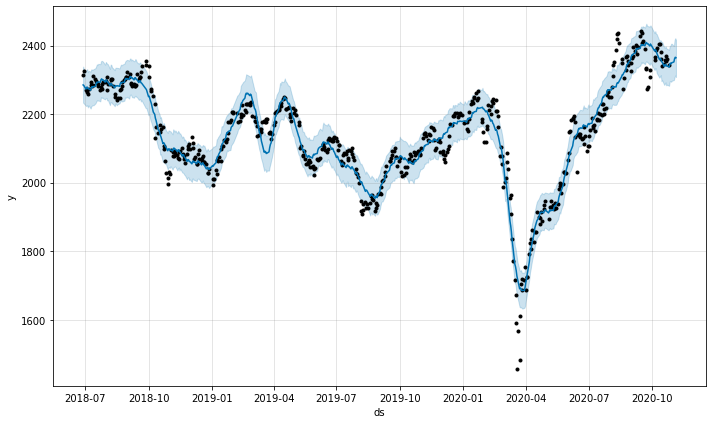

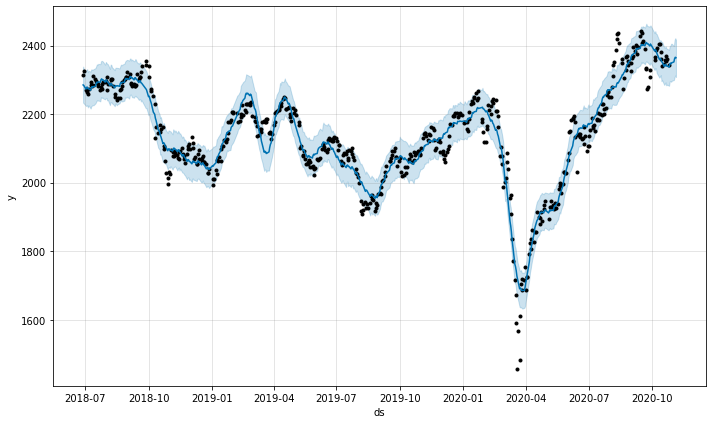

In [36]:
m_kospi.plot(forecast_kospi)

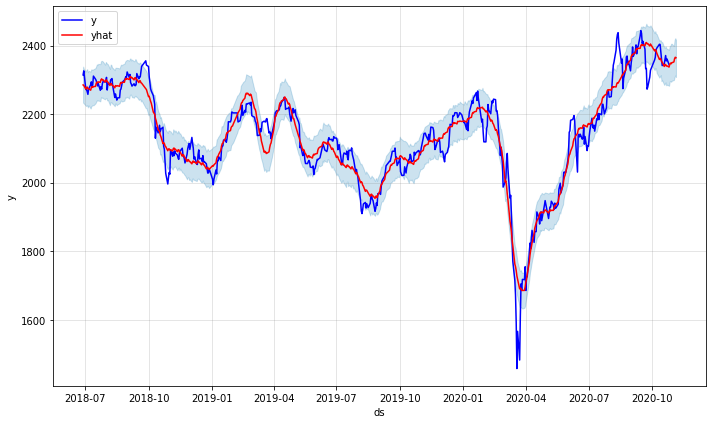

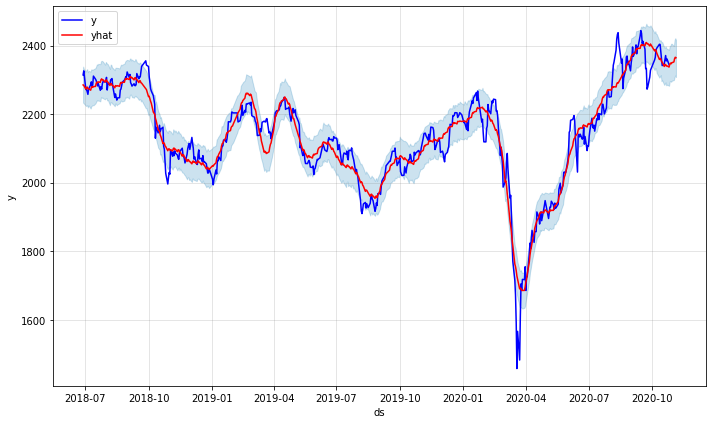

In [37]:
# 위 scatter point를 선으로 연결하여 plot

def plot2(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6) ): 
    
    
    if ax is None: 
        fig = plt.figure(facecolor='w', figsize=figsize) 
        ax = fig.add_subplot(111) 
        
    else: 
        fig = ax.get_figure() 
    fcst_t = fcst['ds'].dt.to_pydatetime() 
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'],'b-')  # train시 사용한 데이터를 검정색으로
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='r')                 # 예측값을 퍼렁색으로
    ax.plot()
    
    # #0072B2
    if 'cap' in fcst and plot_cap: 
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k') 
        
    if m.logistic_floor and 'floor' in fcst and plot_cap: 
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k') 
    ax.plot()
    if uncertainty: 
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'], color='#0072B2', alpha=0.2) 
        
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2) 
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel) 
    ax.legend(['y','yhat'])
    fig.tight_layout() 
    return fig



plot2(m_kospi,forecast_kospi)                  


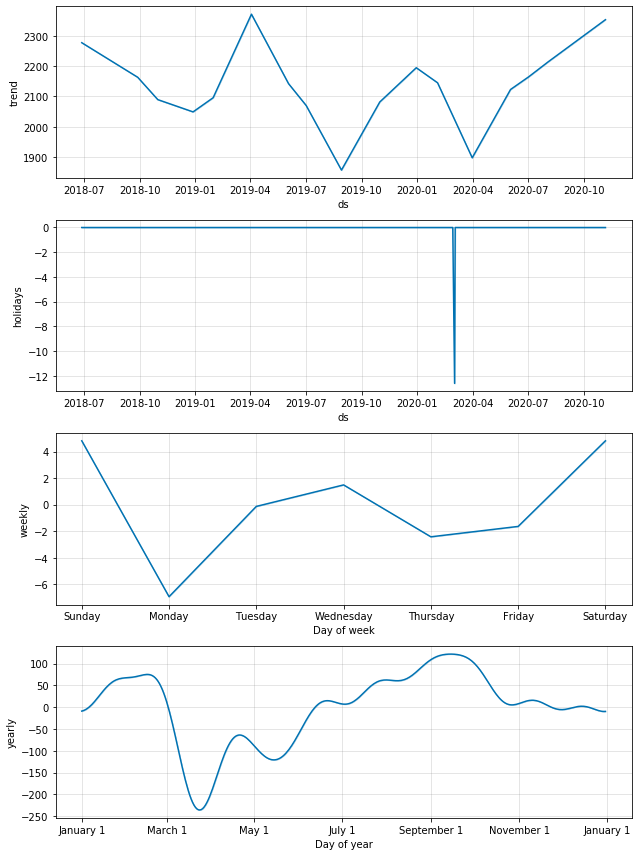

In [38]:
# 예측
fig2 = m_kospi.plot_components(forecast_kospi)

# 코스피지수의 경우, 일주일중, 수요일이 높은 경향이 있음을 확인하였다

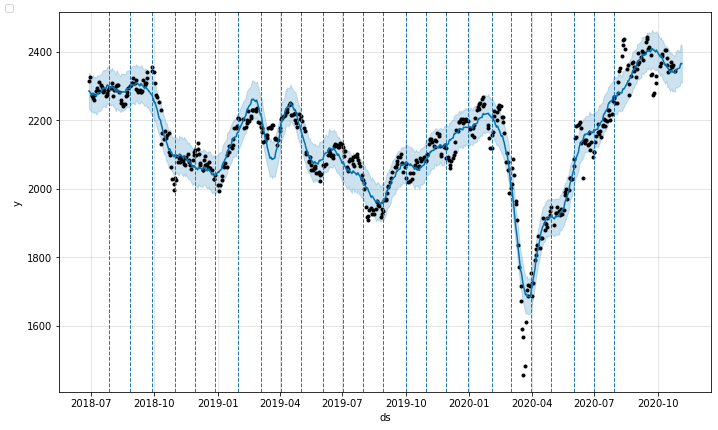

In [39]:
figure = m_kospi.plot(forecast_kospi)
for changepoint in m_kospi.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)      # changing_point선 생성
figure.legend(loc=2)                            # 박스안 위치 조정


In [40]:
pred_kospi=forecast_kospi.tail(pred_days)
pred_kospi

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Chuseok,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
570,2020-10-23,2334.186881,2285.846821,2390.468950,2334.186881,2334.186881,0.0,0.0,0.0,0.0,...,-1.638320,-1.638320,-1.638320,8.166398,8.166398,8.166398,0.0,0.0,0.0,2340.714959
571,2020-10-26,2338.617373,2282.517874,2387.745145,2338.617373,2338.617373,0.0,0.0,0.0,0.0,...,-6.937598,-6.937598,-6.937598,5.531113,5.531113,5.531113,0.0,0.0,0.0,2337.210887
572,2020-10-27,2340.094203,2295.552080,2399.096682,2340.094203,2340.094203,0.0,0.0,0.0,0.0,...,-0.129569,-0.129569,-0.129569,5.427604,5.427604,5.427604,0.0,0.0,0.0,2345.392238
573,2020-10-28,2341.571034,2296.620440,2399.119268,2341.571034,2341.571034,0.0,0.0,0.0,0.0,...,1.491728,1.491728,1.491728,5.655010,5.655010,5.655010,0.0,0.0,0.0,2348.717771
574,2020-10-29,2343.047864,2294.089160,2405.307950,2343.047864,2343.047864,0.0,0.0,0.0,0.0,...,-2.421333,-2.421333,-2.421333,6.169785,6.169785,6.169785,0.0,0.0,0.0,2346.796316
575,2020-10-30,2344.524694,2297.258172,2405.221379,2344.524694,2344.524694,0.0,0.0,0.0,0.0,...,-1.638320,-1.638320,-1.638320,6.923456,6.923456,6.923456,0.0,0.0,0.0,2349.809830
576,2020-11-02,2348.955186,2299.324659,2398.287782,2348.955186,2348.955186,0.0,0.0,0.0,0.0,...,-6.937598,-6.937598,-6.937598,10.085853,10.085853,10.085853,0.0,0.0,0.0,2352.103440
577,2020-11-03,2350.432016,2307.922519,2416.533124,2350.432016,2350.793592,0.0,0.0,0.0,0.0,...,-0.129569,-0.129569,-0.129569,11.256960,11.256960,11.256960,0.0,0.0,0.0,2361.559407
578,2020-11-04,2351.908847,2312.893197,2421.536681,2351.880439,2352.970103,0.0,0.0,0.0,0.0,...,1.491728,1.491728,1.491728,12.396647,12.396647,12.396647,0.0,0.0,0.0,2365.797221
579,2020-11-05,2353.385677,2308.471141,2416.910581,2352.737882,2355.139436,0.0,0.0,0.0,0.0,...,-2.421333,-2.421333,-2.421333,13.454955,13.454955,13.454955,0.0,0.0,0.0,2364.419299


# Cross Validation

- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period
- period : the spacing between cutoff dates
- horizon : the forecast horizon((ds minus cutoff)
- By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon

In [41]:
from fbprophet.diagnostics import cross_validation
df_kospi.shape

(572, 55)

In [42]:
#  validation(the size of the initial training period / the spacing between cutoff dates / specify the forecast horizon)
cv_kospi = cross_validation(m_kospi,initial='200 days', period='20 days', horizon = '10 days')
cv_kospi.head()

INFO:fbprophet:Making 33 forecasts with cutoffs between 2019-01-15 00:00:00 and 2020-10-16 00:00:00


C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the 

C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-16,2118.618658,2091.357226,2146.047378,2106.10,2019-01-15
1,2019-01-17,2131.132833,2105.370924,2157.662583,2107.06,2019-01-15
2,2019-01-18,2160.868721,2134.110896,2187.648101,2124.28,2019-01-15
3,2019-01-21,2241.790548,2216.096245,2270.057832,2124.61,2019-01-15
4,2019-01-22,2276.304399,2249.520604,2303.444703,2117.77,2019-01-15


In [43]:
# compute some useful statistics of the prediction performance as a function of the distance from the cutoff
from fbprophet.diagnostics import performance_metrics
dfpm_kospi = performance_metrics(cv_kospi)
dfpm_kospi

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,3054.666170,55.269034,46.384306,0.022626,0.018243,0.409091
1,3 days,5506.188196,74.203694,59.074559,0.028781,0.024800,0.320000
2,4 days,7486.369019,86.523806,71.860532,0.034340,0.029315,0.318182
3,5 days,5092.036062,71.358504,55.487934,0.026118,0.016842,0.423554
4,6 days,8018.997341,89.548854,63.511655,0.030689,0.021220,0.428571
5,7 days,16156.741854,127.109173,96.862419,0.046977,0.030560,0.181818
6,8 days,20391.294886,142.798091,102.366939,0.050782,0.036205,0.347826
7,9 days,29447.915195,171.603949,116.192241,0.059371,0.024104,0.416667
8,10 days,45657.526313,213.676218,144.934505,0.070163,0.038001,0.291667


In [44]:
dfpm_kospi

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,3054.666170,55.269034,46.384306,0.022626,0.018243,0.409091
1,3 days,5506.188196,74.203694,59.074559,0.028781,0.024800,0.320000
2,4 days,7486.369019,86.523806,71.860532,0.034340,0.029315,0.318182
3,5 days,5092.036062,71.358504,55.487934,0.026118,0.016842,0.423554
4,6 days,8018.997341,89.548854,63.511655,0.030689,0.021220,0.428571
5,7 days,16156.741854,127.109173,96.862419,0.046977,0.030560,0.181818
6,8 days,20391.294886,142.798091,102.366939,0.050782,0.036205,0.347826
7,9 days,29447.915195,171.603949,116.192241,0.059371,0.024104,0.416667
8,10 days,45657.526313,213.676218,144.934505,0.070163,0.038001,0.291667


# Visualizing Performance Metrics
- cutoff: how far into the future the prediction was

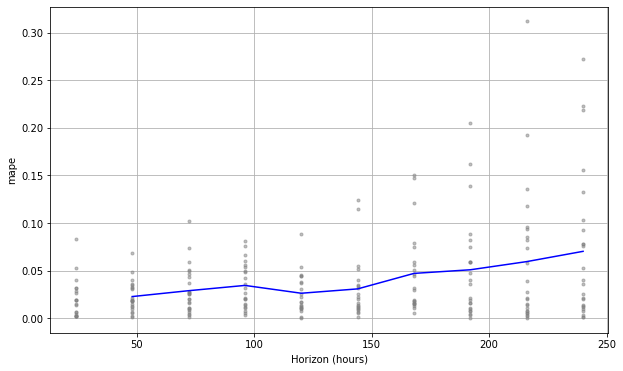

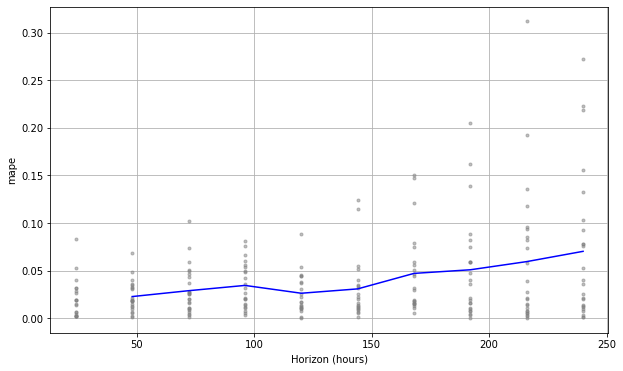

In [45]:
# Cross validation performance metrics can be visualized with
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv_kospi,metric='mape')

# 2) YG

In [46]:
# 함수를 이용하여 요약 통게량을 출력.
model_yg.describe()

,Open,High,Low,Close,Volume,Market_Value_x,Value_x,Num_Stock_x,ma_5,ma_10,...,kosdaq_inst_value,kosdaq_indi_value,kosdaq_fore_value,kosdaq_etc_value,kosdaq_short_sell_value,kosdaq_150_Close,kosdaq_150_comm_Close,kosdaq_enter_Close,kosdaq_large_Close,kosdaq_super_Close
count,487.000000,487.000000,487.000000,487.000000,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02,487.000000,487.000000,...,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02,4.870000e+02,487.000000,487.000000,487.000000,487.000000,487.000000
mean,34483.880903,35310.882957,33618.172485,34473.203285,3.974229e+05,6.280884e+05,1.463741e+10,1.821314e+07,34485.995893,34488.490760,...,2.035074e+10,1.667638e+09,5.645145e+10,1.948565e+07,7.848931e+10,1096.921602,2151.924949,504.217146,1462.828378,1289.812505
std,8960.608349,9127.093291,8640.047162,8904.922207,4.455559e+05,1.633860e+05,1.834786e+10,4.982613e+04,8843.739676,8796.899024,...,1.360266e+10,1.524046e+09,4.237444e+10,6.328542e+07,5.538312e+10,141.273407,253.594699,70.076553,185.664944,142.486236
min,19600.000000,20100.000000,18950.000000,19450.000000,5.555200e+04,3.539430e+05,1.452516e+09,1.818571e+07,20440.000000,21005.000000,...,4.707566e+08,0.000000e+00,0.000000e+00,0.000000e+00,4.707566e+08,697.380000,1353.930000,299.780000,939.400000,830.510000
25%,26900.000000,27475.000000,26250.000000,26900.000000,1.998300e+05,4.895160e+05,5.840409e+09,1.819111e+07,26845.000000,26740.000000,...,5.728783e+09,0.000000e+00,0.000000e+00,0.000000e+00,5.728783e+09,982.955000,1973.375000,459.030000,1316.590000,1202.450000
50%,33000.000000,33800.000000,32400.000000,33300.000000,2.885170e+05,6.059800e+05,9.753320e+09,1.819761e+07,33010.000000,33070.000000,...,2.094021e+10,1.689195e+09,6.611948e+10,0.000000e+00,9.145540e+10,1099.740000,2132.700000,495.440000,1457.660000,1261.410000
75%,41300.000000,42325.000000,40375.000000,41250.000000,4.481335e+05,7.501605e+05,1.652700e+10,1.820381e+07,40980.000000,40952.500000,...,2.922786e+10,2.443358e+09,8.520516e+10,3.022502e+06,1.154052e+11,1209.845000,2362.755000,560.800000,1597.405000,1354.945000
max,59300.000000,60500.000000,57500.000000,58700.000000,5.841435e+06,1.075928e+06,2.310705e+11,1.841097e+07,58140.000000,57590.000000,...,6.626499e+10,1.267690e+10,1.742163e+11,7.850132e+08,2.265522e+11,1398.040000,2647.010000,659.550000,1885.260000,1652.340000


In [47]:
df_yg=copy.deepcopy(model_yg)

In [48]:
#df.date = df.date.astype(str)
#df.date = df.date.str[:4] + '-' + df.date.str[4:6] + '-' + df.date.str[6:]
df_yg['date'] = pd.to_datetime(df_yg.index)

data_yg = df_yg[['date', 'Close']].reset_index(drop=True)

data_yg = data_yg.rename(columns={'date': 'ds', 'Close': 'y'})

data_yg.head()

,ds,y
0,2018-10-18,40000
1,2018-10-19,41200
2,2018-10-22,41750
3,2018-10-23,42700
4,2018-10-24,37050


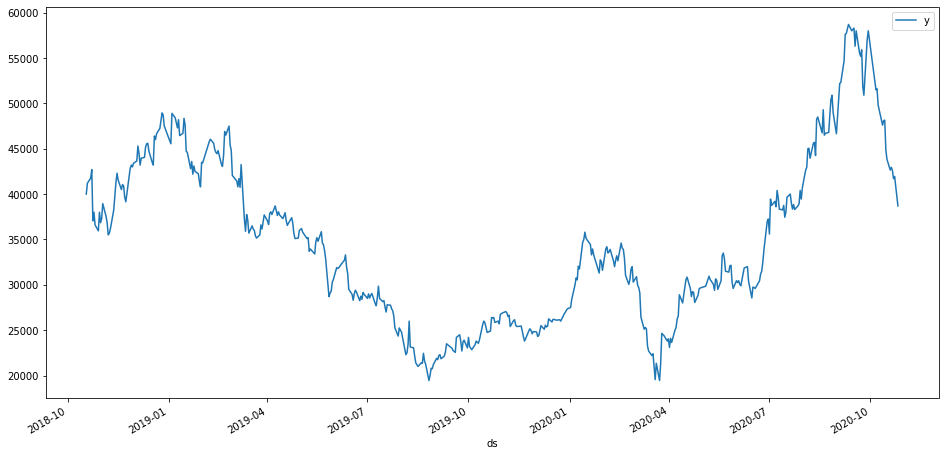

In [49]:
# 데이터의 추이 파악
data_yg.plot(x='ds', y='y', figsize=(16, 8))

In [50]:
'''
cp=['2019-10-23', '2019-11-04', '2019-11-13', '2019-11-22', '2019-12-04', '2019-12-13', '2019-12-26', '2020-01-08', '2020-01-17', '2020-01-31', '2020-02-11', '2020-02-20', '2020-03-03', '2020-03-12', '2020-03-23', '2020-04-02', '2020-04-13', '2020-04-23', '2020-05-08', '2020-05-19', '2020-05-29', '2020-06-09', '2020-06-18', '2020-06-30', '2020-07-09']

Changing_Point

cp_spc=[
 '2020-06-01',
 '2020-06-20',
 '2020-06-23',
 '2020-06-27',
 '2020-07-31',
 '2020-08-11',
 '2020-08-11',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08']

cp_default=['2018-10-29',
    '2018-11-19',
    '2018-12-11',
    '2019-01-04',
    '2019-01-29',
    '2019-02-22',
   '2019-03-19',
   '2019-04-10',
   '2019-05-03',
   '2019-05-27',
   '2019-06-19',
   '2019-07-10',
   '2019-08-01',
   '2019-08-26',
   '2019-09-20',
   '2019-10-15',
   '2019-11-07',
   '2019-11-29',
   '2019-12-26',
   '2020-01-20',
   '2020-02-13',
   '2020-03-05',
   '2020-03-30',
   '2020-04-21',
   '2020-05-18']
cp=cp_default+cp_spc
cp
'''

"\ncp=['2019-10-23', '2019-11-04', '2019-11-13', '2019-11-22', '2019-12-04', '2019-12-13', '2019-12-26', '2020-01-08', '2020-01-17', '2020-01-31', '2020-02-11', '2020-02-20', '2020-03-03', '2020-03-12', '2020-03-23', '2020-04-02', '2020-04-13', '2020-04-23', '2020-05-08', '2020-05-19', '2020-05-29', '2020-06-09', '2020-06-18', '2020-06-30', '2020-07-09']\n\nChanging_Point\n\ncp_spc=[\n '2020-06-01',\n '2020-06-20',\n '2020-06-23',\n '2020-06-27',\n '2020-07-31',\n '2020-08-11',\n '2020-08-11',\n '2020-08-13',\n '2020-08-18',\n '2020-08-19',\n '2020-08-20',\n '2020-08-26',\n '2020-08-28',\n '2020-08-31',\n '2020-09-02',\n '2020-09-03',\n '2020-09-07',\n '2020-09-08']\n\ncp_default=['2018-10-29',\n    '2018-11-19',\n    '2018-12-11',\n    '2019-01-04',\n    '2019-01-29',\n    '2019-02-22',\n   '2019-03-19',\n   '2019-04-10',\n   '2019-05-03',\n   '2019-05-27',\n   '2019-06-19',\n   '2019-07-10',\n   '2019-08-01',\n   '2019-08-26',\n   '2019-09-20',\n   '2019-10-15',\n   '2019-11-07',\n  

In [51]:
from fbprophet import Prophet
from workalendar.asia import SouthKorea


#     growth='linear',
#     #changepoints=cp_1,
#     #n_changepoints=25,
#     changepoint_range=0.95,
#     yearly_seasonality='auto',
#     weekly_seasonality='auto',
#     daily_seasonality='auto',
#     holidays=None,
#     seasonality_mode='additive',
#     seasonality_prior_scale=10.0,
#     holidays_prior_scale=10.0,
#     changepoint_prior_scale=0.05,
#     mcmc_samples=0,
#     interval_width=0.8,
#     uncertainty_samples=1000,
#     stan_backend=None,

m_yg = Prophet(yearly_seasonality='auto',        # Fit yearly seasonality
     weekly_seasonality='auto',
     daily_seasonality='auto',
#      changepoints=cp,
     changepoint_range=0.85,                  # changepoint의 유연성 조절, 오버피팅-> 너무 유연, 언더피팅 -> 유연성 부족   
     changepoint_prior_scale=0.25              # 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 ChangePoint를 지정
     )
m_yg.fit(data_yg)
kor_holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2020))[:, 0])]).reset_index(drop=True)
future_yg = m_yg.make_future_dataframe(periods=pred_days)

future_yg = future_yg[future_yg.ds.dt.weekday != 5]            # 금요일 배제
future_yg = future_yg[future_yg.ds.dt.weekday != 6]            # 토요일 배제
for kor_holiday in kor_holidays:
    future_yg = future_yg[future_yg.ds != kor_holiday]
    
future_yg.tail()
forecast_yg = m_yg.predict(future_yg)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [52]:
# 예측한 YG엔터주 주가 (yhat = yhat_lower와 yhat_upper의 평균)

forecast_yg[ [ 'ds', 'yhat', 'yhat_lower', 'yhat_upper' ] ].tail(pred_days)

,ds,yhat,yhat_lower,yhat_upper
485,2020-10-23,42705.820526,40845.634976,44545.003808
486,2020-10-26,41383.932014,39498.368264,43217.351459
487,2020-10-27,41154.272200,39277.373170,42904.289017
488,2020-10-28,40912.133694,39050.714885,42803.323185
489,2020-10-29,40290.638323,38349.366662,42027.845110
490,2020-10-30,39767.305845,37815.103883,41569.871512
491,2020-11-02,38479.451054,36646.984515,40256.409220
492,2020-11-03,38266.055452,36414.046252,40062.430240
493,2020-11-04,38044.399125,36245.649016,40031.515268
494,2020-11-05,37448.530733,35569.299652,39392.131688


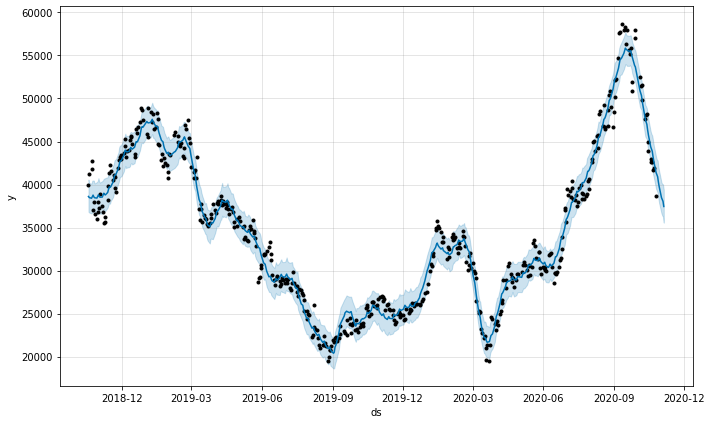

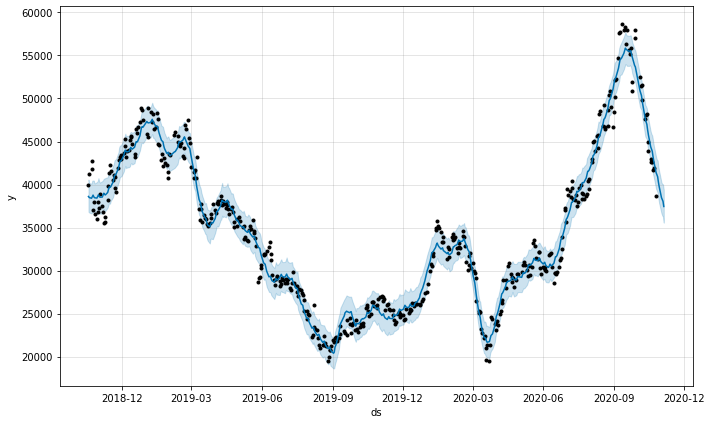

In [53]:
m_yg.plot(forecast_yg)

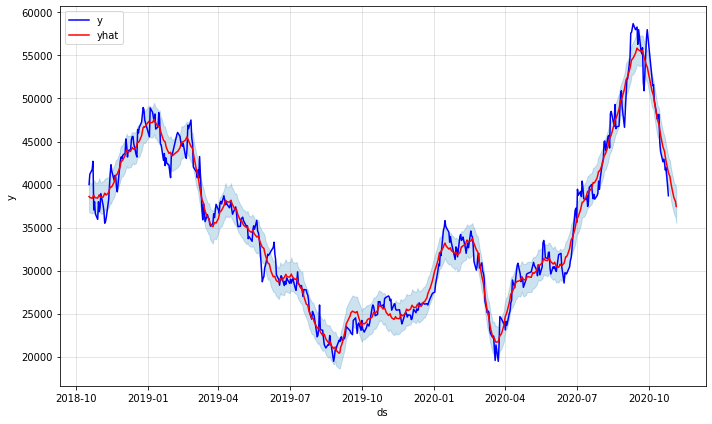

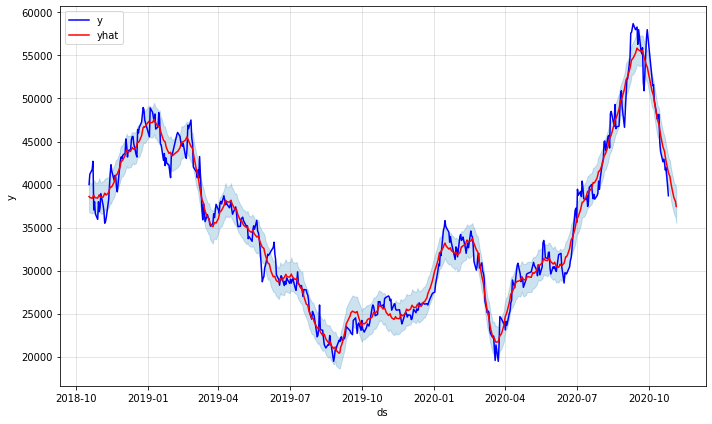

In [54]:
# 위 scatter point를 선으로 연결하여 plot

def plot2(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6) ): 
    
    
    if ax is None: 
        fig = plt.figure(facecolor='w', figsize=figsize) 
        ax = fig.add_subplot(111) 
        
    else: 
        fig = ax.get_figure() 
    fcst_t = fcst['ds'].dt.to_pydatetime() 
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'],'b-')  # train시 사용한 데이터를 검정색으로
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='r')                 # 예측값을 퍼렁색으로
    ax.plot()
    
    # #0072B2
    if 'cap' in fcst and plot_cap: 
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k') 
        
    if m.logistic_floor and 'floor' in fcst and plot_cap: 
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k') 
    ax.plot()
    if uncertainty: 
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'], color='#0072B2', alpha=0.2) 
        
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2) 
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel) 
    ax.legend(['y','yhat'])
    fig.tight_layout() 
    return fig



plot2(m_yg,forecast_yg)                  


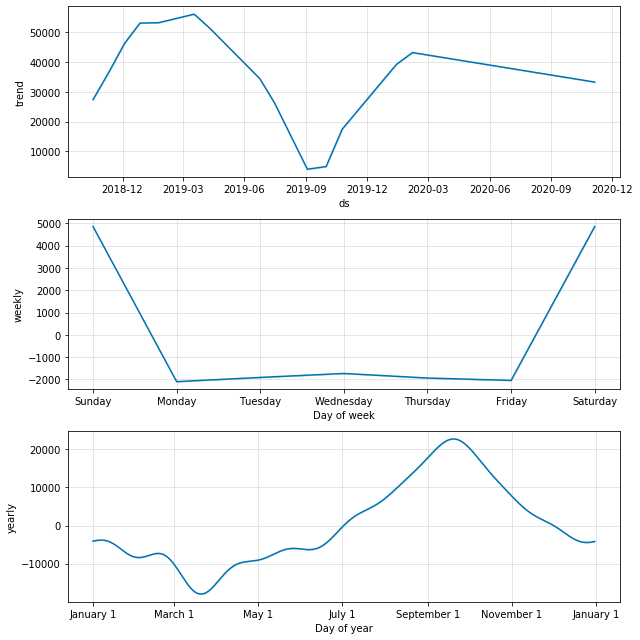

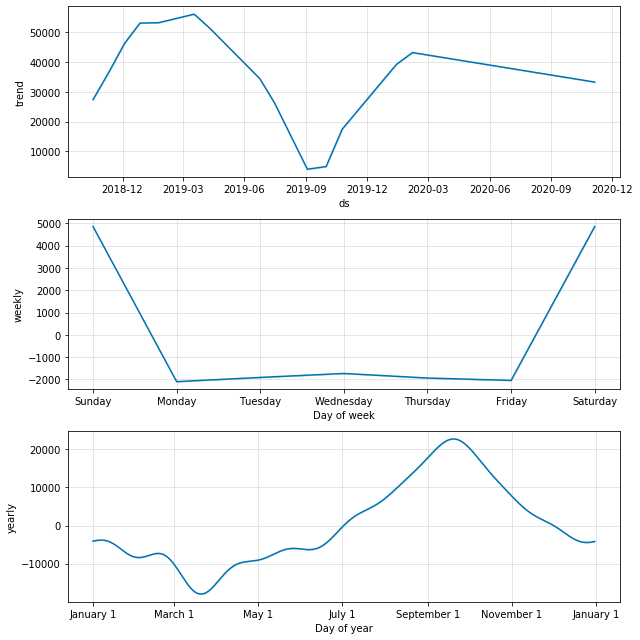

In [55]:
m_yg.plot_components(forecast_yg)

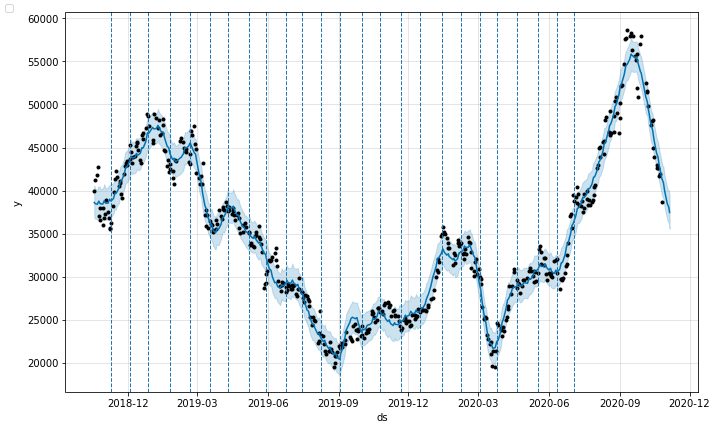

In [56]:
figure = m_yg.plot(forecast_yg)
for changepoint in m_yg.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)
figure.legend(loc=2)

In [57]:
list(m_yg.changepoints)

[Timestamp('2018-11-09 00:00:00'),
 Timestamp('2018-12-04 00:00:00'),
 Timestamp('2018-12-27 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-02-20 00:00:00'),
 Timestamp('2019-03-18 00:00:00'),
 Timestamp('2019-04-10 00:00:00'),
 Timestamp('2019-05-07 00:00:00'),
 Timestamp('2019-05-29 00:00:00'),
 Timestamp('2019-06-24 00:00:00'),
 Timestamp('2019-07-16 00:00:00'),
 Timestamp('2019-08-09 00:00:00'),
 Timestamp('2019-09-03 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-10-25 00:00:00'),
 Timestamp('2019-11-21 00:00:00'),
 Timestamp('2019-12-16 00:00:00'),
 Timestamp('2020-01-14 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-04-21 00:00:00'),
 Timestamp('2020-05-18 00:00:00'),
 Timestamp('2020-06-11 00:00:00'),
 Timestamp('2020-07-03 00:00:00')]

In [58]:
# import pickle
# path=
# with open('model.pckl', 'wb') as fout:
#     pickle.dump(m, fout)  

In [59]:
# 예측한 값만 표로 보기
pred_yg=forecast_yg.tail(pred_days)
pred_yg[['ds','yhat','yhat_lower','yhat_upper','trend']]

,ds,yhat,yhat_lower,yhat_upper,trend
485,2020-10-23,42705.820526,40845.634976,44545.003808,33769.282334
486,2020-10-26,41383.932014,39498.368264,43217.351459,33660.100077
487,2020-10-27,41154.272200,39277.373170,42904.289017,33623.705992
488,2020-10-28,40912.133694,39050.714885,42803.323185,33587.311906
489,2020-10-29,40290.638323,38349.366662,42027.845110,33550.917821
490,2020-10-30,39767.305845,37815.103883,41569.871512,33514.523735
491,2020-11-02,38479.451054,36646.984515,40256.409220,33405.341479
492,2020-11-03,38266.055452,36414.046252,40062.430240,33368.947393
493,2020-11-04,38044.399125,36245.649016,40031.515268,33332.553307
494,2020-11-05,37448.530733,35569.299652,39392.131688,33296.159222


# Cross Validation

- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period 
- period : the spacing between cutoff dates
- horizon : the forecast horizon((ds minus cutoff) ((how frequently to stop and do a prediction). If you don't give them, Prophet will assign defaults of initial = 3 * horizon, and cutoffs every half a horizon.)
- By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon

In [60]:
from fbprophet.diagnostics import cross_validation  # 
cv_yg = cross_validation(m_yg,initial='400 days', period='40 days', horizon = '2 days')
cv_yg.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-11-27 00:00:00 and 2020-10-24 00:00:00


C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-11-28,26270.932829,24798.979157,27653.141899,24600,2019-11-27
1,2019-11-29,26318.269694,24893.608890,27835.895500,24850,2019-11-27
2,2020-01-09,28674.263696,27211.676586,30159.306819,32050,2020-01-08
3,2020-01-10,28498.828596,27016.056042,30037.934901,31750,2020-01-08
4,2020-02-20,34755.030896,33212.863643,36264.996955,32900,2020-02-19


In [61]:
cv_yg.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
11,2020-06-26,31311.684052,29807.636478,32759.419186,33850,2020-06-24
12,2020-08-06,41385.631029,39592.591886,43177.686228,45050,2020-08-05
13,2020-08-07,41372.035409,39515.023922,42930.723243,43950,2020-08-05
14,2020-09-16,59935.855954,58406.300226,61743.259794,58300,2020-09-14
15,2020-10-26,41918.435529,40038.679009,43613.087579,38700,2020-10-24


In [62]:
from fbprophet.diagnostics import performance_metrics
dfpm_yg = performance_metrics(cv_yg)
dfpm_yg.head(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,4.785532e+06,2187.58587,1829.385030,0.055888,0.056384,0.428571
1,2 days,5.900567e+06,2429.10830,2205.179608,0.064454,0.059085,0.222222


# Visualizing Performance Metrics
- cutoff: how far into the future the prediction was

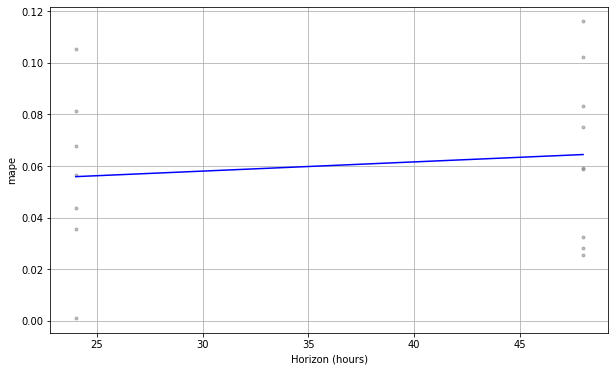

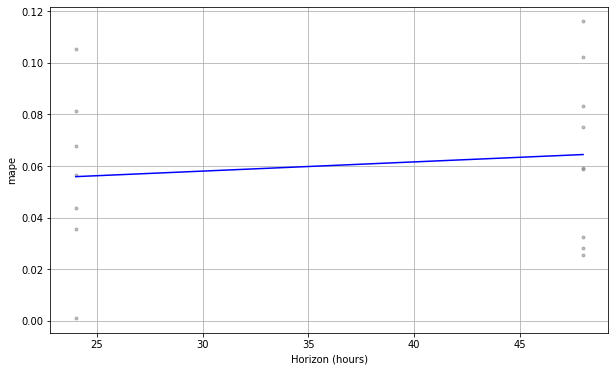

In [63]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv_yg,metric='mape')

# Auto_ML

https://pycaret.org/

1) 예측 대상 설정 및 학습모델 선정 후 생성

In [64]:
print(model_yg.columns)
print(model_kospi.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Value_x', 'Value_x',
       'Num_Stock_x', 'ma_5', 'ma_10', 'ma_15', 'ma_20', 'ma_30', 'ma_60',
       'ma_120', 'ema_5', 'ema_10', 'ema_15', 'ema_20', 'ema_30', 'ema_60',
       'ema_120', 'wma_5', 'wma_10', 'wma_15', 'wma_20', 'wma_30', 'wma_60',
       'wma_120', 'ma_v5', 'ma_v10', 'ma_v20', 'ma_v60', 'ma_v120', 'ubb',
       'mbb', 'lbb', 'macd', 'macdsignal9', 'macdhist', 'rsi', 'slowk',
       'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'cci', 'willR',
       'sar', 'adx', 'plus_di', 'plus_dm', 'atr', 'obv', 'var',
       'Market_Value_y', 'Value_y', 'Num_Stock_y', 'DIV', 'BPS', 'PER', 'EPS',
       'PBR', 'yg_short_sell', 'yg_balance', 'yg_short_sell_value_x',
       'yg_balance_value', 'yg_short_sell_volume', 'yg_total_volume',
       'yg_short_sell_rate', 'yg_short_sell_value_y', 'kosdaq_inst_volume',
       'kosdaq_indi_volume', 'kosdaq_fore_volume', 'kosdaq_etc_volume',
       'kosdaq_short_sell_volume', 'kosd

In [65]:
text_model=input("예측할 대상 입력 : (코스피 OR YG) : ")
text_model=text_model.strip()

if text_model=='코스피':
    # 코스피 지수 예측 모델
    train = model_kospi
    while(1):
        text=int(input("분류모델은 1을 입력 / 회귀모델은 2를 입력 : "))
        if text==1:
            clf = setup(data = train, target = 'Labeling', feature_selection = True, ignore_low_variance = True)
            break
        elif text==2:
            train=copy.deepcopy(model_kospi)
            train=train[train.columns.difference(['Labeling'])]
            #del train['Labeling']
            reg = setup(data = train, target = 'Close', feature_selection = True, ignore_low_variance = True)
            break
        else:
            print("다시 입력하세요")

        
else:
    # 와이지엔터테인먼트 주가 예측 모델
    train = model_yg
    while(1):
        text=int(input("분류모델은 1을 입력 / 회귀모델은 2를 입력 : "))
        if text==1:
            from pycaret.classification import * # AutoML pycaret
            clf = setup(data = train, target = 'Labeling', feature_selection = True, ignore_low_variance = True)
            break
        elif text==2:
            
            train=copy.deepcopy(model_yg)
            train=train[train.columns.difference(['Labeling  '])]
            #del train['Labeling']
            print(train)
            reg = setup(data = train, target = 'Close', feature_selection = True, ignore_low_variance = True)
            break
        else:
            print("다시 입력하세요")

 
Setup Succesfully Completed.


,Description,Value
0,session_id,3512
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(572, 53)"
4,Missing Values,False
5,Numeric Features,52
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:setup() succesfully completed......................................


In [66]:
# return best model based on Recall  # mse기준
best_3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,TheilSen Regressor,2.0841,10.4049,3.1098,0.9995,0.0016,0.0010,4.1449
1,Linear Regression,2.2574,12.7763,3.4210,0.9994,0.0018,0.0011,0.0205
2,Random Sample Consensus,2.2575,12.7759,3.4209,0.9994,0.0018,0.0011,0.0175
3,Ridge Regression,2.5310,16.1145,3.8838,0.9992,0.0020,0.0012,0.0093
4,Bayesian Ridge,2.6654,18.2862,4.1157,0.9991,0.0021,0.0013,0.0210
5,Lasso Regression,4.8299,55.0466,7.1576,0.9975,0.0037,0.0023,0.0277
6,Elastic Net,4.7703,53.7922,7.0759,0.9975,0.0036,0.0023,0.0361
7,Orthogonal Matching Pursuit,7.7103,131.7232,11.1969,0.9939,0.0057,0.0037,0.0149
8,Extra Trees Regressor,7.4259,133.3136,11.1491,0.9938,0.0056,0.0036,0.2831
9,Gradient Boosting Regressor,7.8461,159.6497,12.1830,0.9924,0.0063,0.0038,0.4806


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 4
INFO:logs:[TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
                  random_state=3512, tol=0.001, verbose=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False), RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=0.5, random_state=3512, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)]
INFO:logs:compare_models() succesfully completed......................................


In [67]:
# used to blend specific trained models that can be passed using estimator_list parameter
blended = blend_models(estimator_list = best_3, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.4397,17.5161,4.1852,0.9992,0.0024,0.0012
1,1.7001,5.4346,2.3312,0.9997,0.0012,0.0008
2,1.8930,8.6878,2.9475,0.9995,0.0014,0.0009
3,2.3778,10.2666,3.2042,0.9996,0.0016,0.0011
4,2.3740,12.2675,3.5025,0.9994,0.0018,0.0011
Mean,2.1569,10.8345,3.2341,0.9995,0.0017,0.0010
SD,0.3014,4.0196,0.6124,0.0002,0.0004,0.0002


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 5
INFO:logs:VotingRegressor(estimators=[('Theil Sen Regressor_0',
                             TheilSenRegressor(copy_X=True, fit_intercept=True,
                                               max_iter=300,
                                               max_subpopulation=10000,
                                               n_jobs=-1, n_subsamples=None,
                                               random_state=3512, tol=0.001,
                                               verbose=False)),
                            ('Linear Regression_1',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=-1, normalize=False)),
                            ('RANSAC Regressor_2',
                             RANSACRegressor(base_estimator=None,
                                             is_data_valid=None,
             

In [68]:
# can be used to predict on unseen data
pred_holdout = predict_model(blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.1375,10.4703,3.2358,0.9996,0.0018,0.0011


In [69]:
# 초모수 튜닝을 마친 최종모형을 finalize_model()로 뽑아냄
final_model = finalize_model(blended)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=VotingRegressor(estimators=[('Theil Sen Regressor_0',
                             TheilSenRegressor(copy_X=True, fit_intercept=True,
                                               max_iter=300,
                                               max_subpopulation=10000,
                                               n_jobs=-1, n_subsamples=None,
                                               random_state=3512, tol=0.001,
                                               verbose=False)),
                            ('Linear Regression_1',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=-1, normalize=False)),
                            ('RANSAC Regressor_2',
                             RANSACRegressor(base_estimator=None,
                                             is_data_valid=None,
                                             is_model_v

In [70]:
save_model(final_model, model_name = 'deployment')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=VotingRegressor(estimators=[('Theil Sen Regressor_0',
                             TheilSenRegressor(copy_X=True, fit_intercept=True,
                                               max_iter=300,
                                               max_subpopulation=10000,
                                               n_jobs=-1, n_subsamples=None,
                                               random_state=3512, tol=0.001,
                                               verbose=False)),
                            ('Linear Regression_1',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=-1, normalize=False)),
                            ('RANSAC Regressor_2',
                             RANSACRegressor(base_estimator=None,
                                             is_data_valid=None,
                                             is_model_valid=Non

Transformation Pipeline and Model Succesfully Saved


In [71]:
train

,Close,High,Low,Open,Volume,adx,atr,cci,ema_10,ema_120,...,ubb,var,willR,wma_10,wma_120,wma_15,wma_20,wma_30,wma_5,wma_60
날짜,,,,,,,,,,,,,,,,,,,,,
2018-06-28,2314.24,2335.35,2310.80,2327.37,414371000,31.910135,28.197606,-97.443492,2359.553911,2457.214417,...,2501.286188,260.759776,-97.961602,2345.420909,2442.232475,2362.476333,2377.495857,2397.519957,2337.670667,2427.193792
2018-06-29,2326.13,2329.58,2296.39,2325.68,396663000,34.138282,28.554205,-94.052072,2353.476836,2455.047732,...,2502.008477,256.705640,-83.763717,2340.273273,2440.065791,2354.667250,2370.453190,2391.400344,2331.561333,2423.425322
2018-07-02,2271.54,2327.59,2271.53,2322.23,393266000,36.509826,30.518905,-136.506898,2338.579230,2452.014546,...,2506.557073,771.153896,-99.995193,2326.616727,2437.017938,2341.238167,2358.606238,2382.043548,2309.328000,2417.932437
2018-07-03,2272.76,2287.39,2252.36,2285.88,366028000,38.915021,30.841126,-178.371228,2326.612097,2449.051661,...,2505.966173,812.297320,-89.779047,2315.085636,2434.019839,2329.461917,2347.596762,2373.170366,2293.257333,2412.573880
2018-07-04,2265.46,2280.81,2261.34,2270.95,315103000,41.148416,30.028903,-145.805625,2315.493534,2446.017088,...,2502.204771,626.630384,-92.768424,2303.451818,2430.927759,2318.418083,2336.683476,2364.204043,2279.964000,2407.068694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20,2358.41,2358.41,2322.06,2333.56,874293000,13.254001,34.909058,-26.409545,2362.542719,2245.128670,...,2437.425074,182.667944,-39.984133,2367.176000,2295.960346,2364.591750,2359.877429,2365.310581,2353.766667,2363.649885
2020-10-21,2370.86,2371.74,2356.32,2363.03,812837000,13.187585,33.516983,9.653062,2364.054952,2247.206874,...,2432.815080,109.717560,-37.649918,2366.604182,2298.591745,2366.903333,2361.105524,2365.181183,2358.162000,2364.444732
2020-10-22,2355.05,2360.22,2339.73,2355.61,815612000,13.558771,33.346484,-53.923621,2362.417688,2248.989405,...,2425.481996,102.335416,-64.582701,2363.067636,2300.895452,2366.420667,2360.996048,2364.085634,2357.928667,2364.643514


In [72]:
predictions = predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.84,7.2356,2.6899,0.9997,0.0014,0.0009


In [73]:
predictions

,ma_v60,ma_v10,cci,ma_5,wma_120,ema_10,willR,ma_15,ema_20,wma_15,...,ema_60,macdsignal9,slowk,var,atr,ma_v5,Volume,ema_30,Close,Label
0,5.409297e+08,558421300.0,-32.981856,2089.186,2119.509650,2084.998222,-58.701251,2080.837333,2088.735803,2082.778250,...,2104.843140,-5.217898,55.049612,91.623024,21.250698,5.651370e+08,5.986340e+08,2092.324518,2074.48,2073.0856
1,9.465221e+08,871476200.0,-16.497622,2116.944,1978.893729,2130.362729,-40.715704,2139.668000,2101.134239,2141.000333,...,2017.496789,53.249009,79.136227,1862.306904,49.626314,9.640140e+08,1.079453e+09,2068.635628,2141.32,2133.5260
2,5.486416e+08,608495100.0,4.800827,1938.304,2073.529426,1949.498142,-54.174757,1956.337333,1977.098168,1941.898750,...,2042.752500,-38.135275,66.757418,152.749024,25.526908,5.451870e+08,4.636050e+08,2000.086331,1960.25,1959.5371
3,4.828895e+08,329617100.0,22.551689,2289.170,2384.828931,2289.427409,-42.890153,2288.896000,2297.564454,2288.183000,...,2353.323319,-22.583666,91.995280,70.061560,23.208934,2.610446e+08,2.239270e+08,2312.523258,2295.26,2294.3259
4,7.278590e+08,911317800.0,48.398843,1712.238,2030.959395,1696.500110,-33.483833,1664.429333,1756.721571,1663.368917,...,1942.624422,-114.892631,68.088926,648.976576,78.004739,1.023771e+09,1.243591e+09,1823.080987,1685.46,1689.1892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,8.156376e+08,988573300.0,103.489324,1900.408,1971.466029,1881.691407,-5.112400,1864.958000,1850.929916,1884.500417,...,1905.577300,7.369212,78.421863,259.080096,52.756928,8.695908e+08,7.356630e+08,1851.413944,1922.77,1919.9974
168,3.842336e+08,384164100.0,88.302406,2221.288,2152.129802,2208.050027,-0.000000,2185.290667,2194.156640,2203.052833,...,2172.613387,7.239163,92.075831,68.285416,20.169319,4.028128e+08,4.496340e+08,2187.225567,2233.45,2235.7880
169,3.563006e+08,287478300.0,80.917537,2309.882,2341.778941,2298.870588,-15.125489,2280.733333,2291.927843,2294.221917,...,2317.539625,-2.582291,71.456464,45.988696,20.371771,2.636904e+08,2.305130e+08,2293.863358,2307.03,2305.8624
170,5.323713e+08,687627500.0,76.089610,2246.386,2127.004101,2229.497764,-26.908465,2208.275333,2207.859255,2224.489500,...,2156.220684,23.288142,58.309808,113.329704,24.273875,6.902230e+08,7.703200e+08,2191.298130,2239.69,2239.3944


In [74]:
score = predictions[['Close', 'Label']]
#score.to_csv('kospi_score_reg.csv', index = False
score

,Close,Label
0,2074.48,2073.0856
1,2141.32,2133.5260
2,1960.25,1959.5371
3,2295.26,2294.3259
4,1685.46,1689.1892
...,...,...
167,1922.77,1919.9974
168,2233.45,2235.7880
169,2307.03,2305.8624
170,2239.69,2239.3944


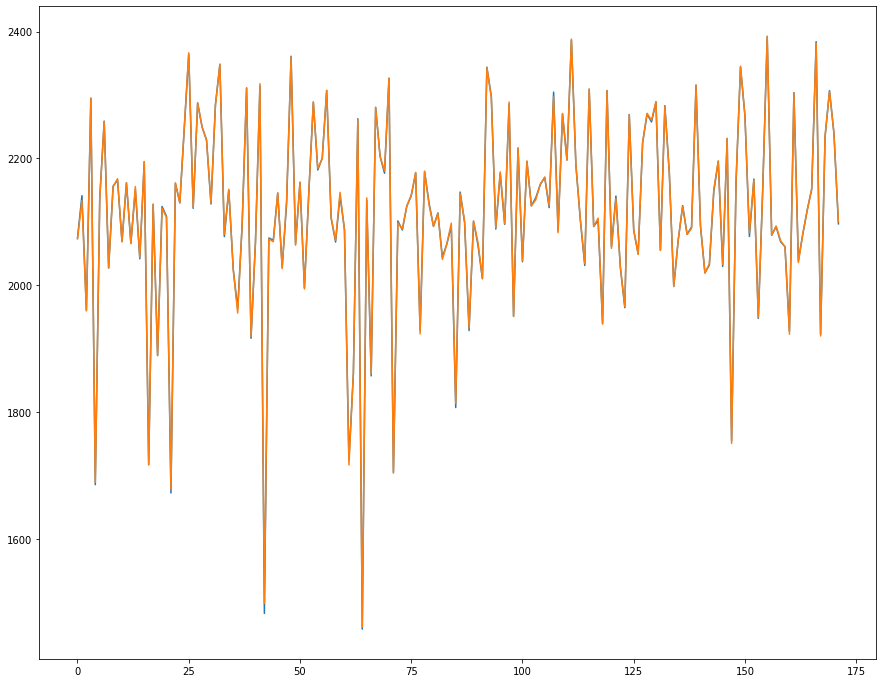

In [75]:
plt.figure(figsize=(15,12))
plt.plot(score)


# fig = plt.figure(figsize=(15,12))
# ax1 = fig.add_subplot(211)
# ax1.plot(score['Close'],color='K',label='Y')
# ax1.plot(score['Label'],color='red',label='Yhat')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('값')
# ax1.legend(loc='best')
# plt.show


# Ex) LightGBM 

In [76]:
lgbm  = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16.5001,1419.7735,37.6799,0.9443,0.0220,0.0091
1,10.0115,278.2431,16.6806,0.9849,0.0084,0.0048
2,9.9234,456.1030,21.3566,0.9770,0.0123,0.0051
3,6.7867,110.6598,10.5195,0.9944,0.0047,0.0031
4,8.0128,111.3844,10.5539,0.9932,0.0050,0.0037
5,10.8832,294.0120,17.1468,0.9824,0.0084,0.0052
6,11.6767,339.0436,18.4131,0.9868,0.0089,0.0056
7,10.1272,237.2943,15.4044,0.9918,0.0081,0.0051
8,8.5512,160.3389,12.6625,0.9892,0.0055,0.0039
9,10.8464,208.4724,14.4386,0.9921,0.0070,0.0052


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 9
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=3512, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [77]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,12.8928,635.0695,25.2006,0.9751,0.0145,0.0069
1,10.1682,306.7009,17.5129,0.9833,0.0086,0.0048
2,8.1207,128.0634,11.3165,0.9935,0.0055,0.0038
3,7.7913,123.4149,11.1092,0.9938,0.0053,0.0037
4,9.5026,149.9302,12.2446,0.9908,0.0057,0.0044
5,9.9577,208.7549,14.4484,0.9875,0.0071,0.0048
6,10.3913,250.3504,15.8225,0.9902,0.0078,0.0050
7,13.4028,356.8993,18.8918,0.9876,0.0094,0.0065
8,9.0165,187.2994,13.6857,0.9874,0.0061,0.0041
9,13.5992,408.0471,20.2002,0.9845,0.0100,0.0066


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 10
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.6,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=3512, reg_alpha=0.6, reg_lambda=0.6, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


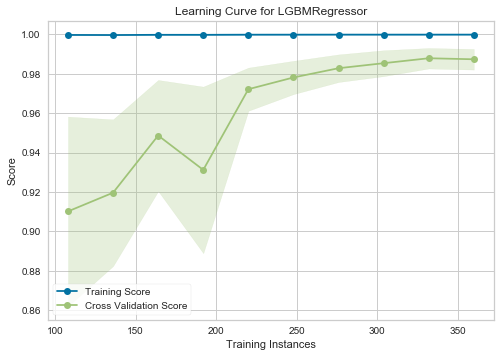

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [78]:
plot_model(tuned_lgbm, plot = 'learning')

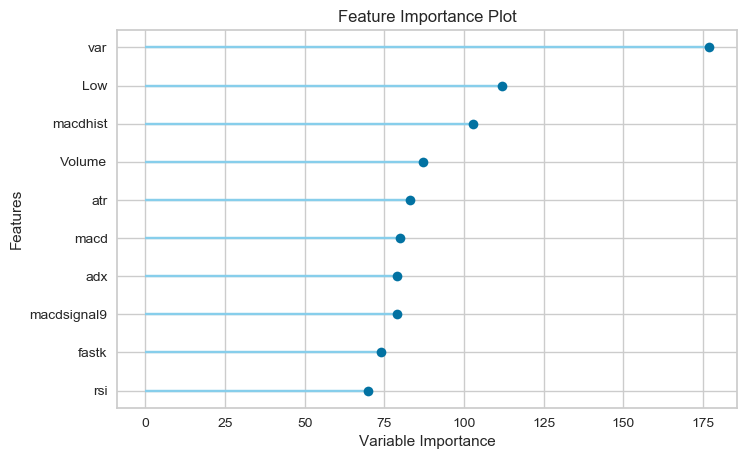

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [79]:
plot_model(estimator = tuned_lgbm, plot = 'feature')

In [80]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [81]:
predict_model(tuned_lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.1442,324.1674,18.0046,0.9866,0.0106,0.0052


,ma_v60,ma_v10,cci,ma_5,wma_120,ema_10,willR,ma_15,ema_20,wma_15,...,ema_60,macdsignal9,slowk,var,atr,ma_v5,Volume,ema_30,Close,Label
0,5.409297e+08,558421300.0,-32.981856,2089.186,2119.509650,2084.998222,-58.701251,2080.837333,2088.735803,2082.778250,...,2104.843140,-5.217898,55.049612,91.623024,21.250698,5.651370e+08,5.986340e+08,2092.324518,2074.48,2075.9964
1,9.465221e+08,871476200.0,-16.497622,2116.944,1978.893729,2130.362729,-40.715704,2139.668000,2101.134239,2141.000333,...,2017.496789,53.249009,79.136227,1862.306904,49.626314,9.640140e+08,1.079453e+09,2068.635628,2141.32,2138.4630
2,5.486416e+08,608495100.0,4.800827,1938.304,2073.529426,1949.498142,-54.174757,1956.337333,1977.098168,1941.898750,...,2042.752500,-38.135275,66.757418,152.749024,25.526908,5.451870e+08,4.636050e+08,2000.086331,1960.25,1945.1260
3,4.828895e+08,329617100.0,22.551689,2289.170,2384.828931,2289.427409,-42.890153,2288.896000,2297.564454,2288.183000,...,2353.323319,-22.583666,91.995280,70.061560,23.208934,2.610446e+08,2.239270e+08,2312.523258,2295.26,2299.3132
4,7.278590e+08,911317800.0,48.398843,1712.238,2030.959395,1696.500110,-33.483833,1664.429333,1756.721571,1663.368917,...,1942.624422,-114.892631,68.088926,648.976576,78.004739,1.023771e+09,1.243591e+09,1823.080987,1685.46,1707.1663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,8.156376e+08,988573300.0,103.489324,1900.408,1971.466029,1881.691407,-5.112400,1864.958000,1850.929916,1884.500417,...,1905.577300,7.369212,78.421863,259.080096,52.756928,8.695908e+08,7.356630e+08,1851.413944,1922.77,1898.0979
168,3.842336e+08,384164100.0,88.302406,2221.288,2152.129802,2208.050027,-0.000000,2185.290667,2194.156640,2203.052833,...,2172.613387,7.239163,92.075831,68.285416,20.169319,4.028128e+08,4.496340e+08,2187.225567,2233.45,2233.5255
169,3.563006e+08,287478300.0,80.917537,2309.882,2341.778941,2298.870588,-15.125489,2280.733333,2291.927843,2294.221917,...,2317.539625,-2.582291,71.456464,45.988696,20.371771,2.636904e+08,2.305130e+08,2293.863358,2307.03,2306.1151
170,5.323713e+08,687627500.0,76.089610,2246.386,2127.004101,2229.497764,-26.908465,2208.275333,2207.859255,2224.489500,...,2156.220684,23.288142,58.309808,113.329704,24.273875,6.902230e+08,7.703200e+08,2191.298130,2239.69,2241.9280


In [82]:
predictions = predict_model(tuned_lgbm)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.1442,324.1674,18.0046,0.9866,0.0106,0.0052


,ma_v60,ma_v10,cci,ma_5,wma_120,ema_10,willR,ma_15,ema_20,wma_15,...,ema_60,macdsignal9,slowk,var,atr,ma_v5,Volume,ema_30,Close,Label
0,5.409297e+08,558421300.0,-32.981856,2089.186,2119.509650,2084.998222,-58.701251,2080.837333,2088.735803,2082.778250,...,2104.843140,-5.217898,55.049612,91.623024,21.250698,5.651370e+08,5.986340e+08,2092.324518,2074.48,2075.9964
1,9.465221e+08,871476200.0,-16.497622,2116.944,1978.893729,2130.362729,-40.715704,2139.668000,2101.134239,2141.000333,...,2017.496789,53.249009,79.136227,1862.306904,49.626314,9.640140e+08,1.079453e+09,2068.635628,2141.32,2138.4630
2,5.486416e+08,608495100.0,4.800827,1938.304,2073.529426,1949.498142,-54.174757,1956.337333,1977.098168,1941.898750,...,2042.752500,-38.135275,66.757418,152.749024,25.526908,5.451870e+08,4.636050e+08,2000.086331,1960.25,1945.1260
3,4.828895e+08,329617100.0,22.551689,2289.170,2384.828931,2289.427409,-42.890153,2288.896000,2297.564454,2288.183000,...,2353.323319,-22.583666,91.995280,70.061560,23.208934,2.610446e+08,2.239270e+08,2312.523258,2295.26,2299.3132
4,7.278590e+08,911317800.0,48.398843,1712.238,2030.959395,1696.500110,-33.483833,1664.429333,1756.721571,1663.368917,...,1942.624422,-114.892631,68.088926,648.976576,78.004739,1.023771e+09,1.243591e+09,1823.080987,1685.46,1707.1663


In [83]:
score = predictions[['Close', 'Label']]
#score.to_csv('kospi_score_reg.csv', index = False)
score.head()

,Close,Label
0,2074.48,2075.9964
1,2141.32,2138.4630
2,1960.25,1945.1260
3,2295.26,2299.3132
4,1685.46,1707.1663


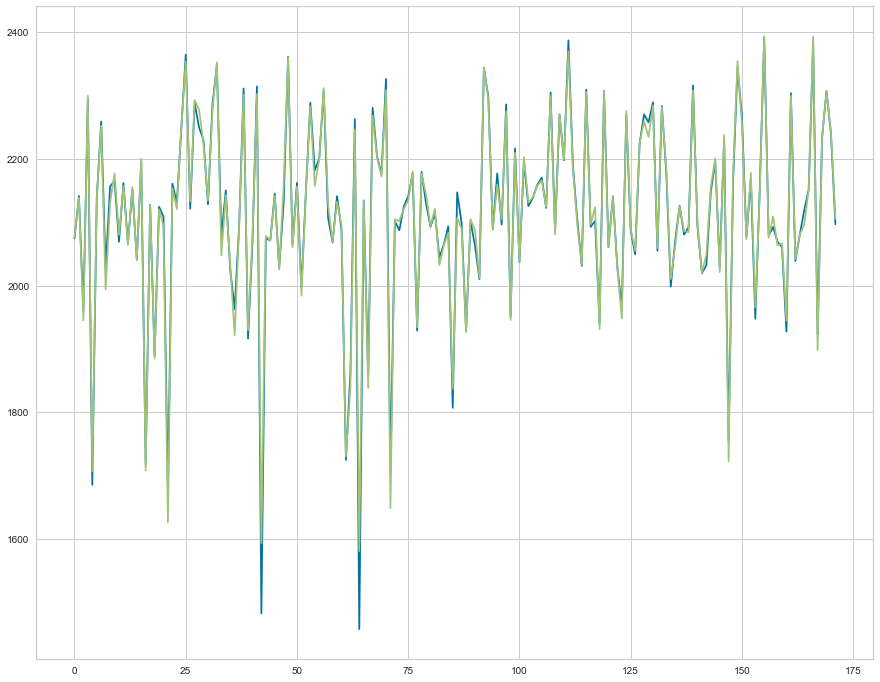

In [84]:
plt.figure(figsize=(15,12))
plt.plot(score)